In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import time
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import gym_Aircraft

In [2]:
env = gym.make("acav-v0")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)

In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [6]:
policy_net = nn.DataParallel(DQN(env.observation_space.shape[0], env.action_space.n).to(device))
target_net = nn.DataParallel(DQN(env.observation_space.shape[0], env.action_space.n).to(device))
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DataParallel(
  (module): DQN(
    (layers): Sequential(
      (0): Linear(in_features=5, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): ReLU()
      (4): Linear(in_features=40, out_features=40, bias=True)
      (5): ReLU()
      (6): Linear(in_features=40, out_features=40, bias=True)
      (7): ReLU()
      (8): Linear(in_features=40, out_features=40, bias=True)
      (9): ReLU()
      (10): Linear(in_features=40, out_features=40, bias=True)
      (11): ReLU()
      (12): Linear(in_features=40, out_features=40, bias=True)
      (13): ReLU()
      (14): Linear(in_features=40, out_features=3, bias=True)
    )
  )
)

In [7]:
n_actions = env.action_space.n

In [8]:
optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(10000)

In [9]:
steps_done = 0

In [10]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [12]:
num_episodes = 10000
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()
    state=torch.from_numpy(state.astype(np.float32)).unsqueeze(0).to(device)
    for t in count():
        # 행동 선택과 수행
        
        action = select_action(state)
        next_state, reward, done, res = env.step(action.item())
        reward = torch.tensor([reward], dtype=torch.float32).to(device)
        
        next_state=torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).to(device)

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # 최적화 한단계 수행(목표 네트워크에서)
        optimize_model()
        
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {}".format(i_episode, t, total_reward.item()))
            break
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.close()

2020/10/02 00:02:29
episode : 0 | final step : 97 | total reward : -760.0
2020/10/02 00:02:39
episode : 1 | final step : 99 | total reward : -450.0
2020/10/02 00:02:42
episode : 2 | final step : 98 | total reward : -310.0
2020/10/02 00:02:45
episode : 3 | final step : 100 | total reward : -100.0
2020/10/02 00:02:47
episode : 4 | final step : 102 | total reward : -140.0
2020/10/02 00:02:50
episode : 5 | final step : 94 | total reward : -90.0
2020/10/02 00:02:53
episode : 6 | final step : 97 | total reward : -40.0
2020/10/02 00:02:56
episode : 7 | final step : 99 | total reward : -30.0
2020/10/02 00:02:58
episode : 8 | final step : 100 | total reward : -30.0
2020/10/02 00:03:02
episode : 9 | final step : 101 | total reward : -40.0
2020/10/02 00:03:04
episode : 10 | final step : 97 | total reward : -30.0
2020/10/02 00:03:07
episode : 11 | final step : 100 | total reward : -50.0
2020/10/02 00:03:10
episode : 12 | final step : 101 | total reward : -20.0
2020/10/02 00:03:13
episode : 13 | fi

2020/10/02 00:07:58
episode : 111 | final step : 101 | total reward : -40.0
2020/10/02 00:08:01
episode : 112 | final step : 98 | total reward : -20.0
2020/10/02 00:08:04
episode : 113 | final step : 95 | total reward : -10.0
2020/10/02 00:08:07
episode : 114 | final step : 95 | total reward : -50.0
2020/10/02 00:08:10
episode : 115 | final step : 100 | total reward : -40.0
2020/10/02 00:08:13
episode : 116 | final step : 98 | total reward : -50.0
2020/10/02 00:08:16
episode : 117 | final step : 98 | total reward : -40.0
2020/10/02 00:08:19
episode : 118 | final step : 93 | total reward : -30.0
2020/10/02 00:08:22
episode : 119 | final step : 99 | total reward : -50.0
2020/10/02 00:08:25
episode : 120 | final step : 100 | total reward : -80.0
2020/10/02 00:08:28
episode : 121 | final step : 99 | total reward : -20.0
2020/10/02 00:08:31
episode : 122 | final step : 100 | total reward : -30.0
2020/10/02 00:08:34
episode : 123 | final step : 99 | total reward : -20.0
2020/10/02 00:08:37
e

2020/10/02 00:13:35
episode : 220 | final step : 98 | total reward : -50.0
2020/10/02 00:13:38
episode : 221 | final step : 99 | total reward : -50.0
2020/10/02 00:13:41
episode : 222 | final step : 100 | total reward : -10.0
2020/10/02 00:13:44
episode : 223 | final step : 98 | total reward : -30.0
2020/10/02 00:13:47
episode : 224 | final step : 99 | total reward : -50.0
2020/10/02 00:13:50
episode : 225 | final step : 96 | total reward : -40.0
2020/10/02 00:13:54
episode : 226 | final step : 99 | total reward : -30.0
2020/10/02 00:13:57
episode : 227 | final step : 97 | total reward : -30.0
2020/10/02 00:14:00
episode : 228 | final step : 95 | total reward : -20.0
2020/10/02 00:14:03
episode : 229 | final step : 96 | total reward : -40.0
2020/10/02 00:14:06
episode : 230 | final step : 95 | total reward : -20.0
2020/10/02 00:14:09
episode : 231 | final step : 100 | total reward : -50.0
2020/10/02 00:14:12
episode : 232 | final step : 98 | total reward : -10.0
2020/10/02 00:14:15
epi

2020/10/02 00:19:16
episode : 329 | final step : 100 | total reward : -30.0
2020/10/02 00:19:19
episode : 330 | final step : 95 | total reward : -10.0
2020/10/02 00:19:22
episode : 331 | final step : 100 | total reward : -40.0
2020/10/02 00:19:26
episode : 332 | final step : 98 | total reward : -40.0
2020/10/02 00:19:29
episode : 333 | final step : 97 | total reward : -50.0
2020/10/02 00:19:32
episode : 334 | final step : 100 | total reward : -10.0
2020/10/02 00:19:35
episode : 335 | final step : 95 | total reward : -20.0
2020/10/02 00:19:38
episode : 336 | final step : 96 | total reward : -40.0
2020/10/02 00:19:41
episode : 337 | final step : 99 | total reward : -40.0
2020/10/02 00:19:44
episode : 338 | final step : 97 | total reward : -40.0
2020/10/02 00:19:47
episode : 339 | final step : 97 | total reward : -50.0
2020/10/02 00:19:50
episode : 340 | final step : 99 | total reward : -30.0
2020/10/02 00:19:53
episode : 341 | final step : 94 | total reward : -20.0
2020/10/02 00:19:56
ep

2020/10/02 00:25:00
episode : 438 | final step : 99 | total reward : -20.0
2020/10/02 00:25:03
episode : 439 | final step : 99 | total reward : -40.0
2020/10/02 00:25:06
episode : 440 | final step : 98 | total reward : -40.0
2020/10/02 00:25:09
episode : 441 | final step : 98 | total reward : -30.0
2020/10/02 00:25:12
episode : 442 | final step : 97 | total reward : -30.0
2020/10/02 00:25:16
episode : 443 | final step : 99 | total reward : -30.0
2020/10/02 00:25:19
episode : 444 | final step : 100 | total reward : -10.0
2020/10/02 00:25:22
episode : 445 | final step : 98 | total reward : -60.0
2020/10/02 00:25:25
episode : 446 | final step : 98 | total reward : -70.0
2020/10/02 00:25:28
episode : 447 | final step : 99 | total reward : -60.0
2020/10/02 00:25:31
episode : 448 | final step : 96 | total reward : -40.0
2020/10/02 00:25:34
episode : 449 | final step : 100 | total reward : -20.0
2020/10/02 00:25:38
episode : 450 | final step : 97 | total reward : -40.0
2020/10/02 00:25:41
epi

2020/10/02 00:30:42
episode : 547 | final step : 98 | total reward : -10.0
2020/10/02 00:30:45
episode : 548 | final step : 96 | total reward : -20.0
2020/10/02 00:30:48
episode : 549 | final step : 99 | total reward : -30.0
2020/10/02 00:30:52
episode : 550 | final step : 100 | total reward : -70.0
2020/10/02 00:30:55
episode : 551 | final step : 100 | total reward : -70.0
2020/10/02 00:30:58
episode : 552 | final step : 98 | total reward : -10.0
2020/10/02 00:31:01
episode : 553 | final step : 101 | total reward : -40.0
2020/10/02 00:31:04
episode : 554 | final step : 98 | total reward : -60.0
2020/10/02 00:31:07
episode : 555 | final step : 99 | total reward : 0.0
2020/10/02 00:31:11
episode : 556 | final step : 97 | total reward : -10.0
2020/10/02 00:31:14
episode : 557 | final step : 99 | total reward : -30.0
2020/10/02 00:31:17
episode : 558 | final step : 98 | total reward : -40.0
2020/10/02 00:31:20
episode : 559 | final step : 96 | total reward : -20.0
2020/10/02 00:31:23
epis

2020/10/02 00:36:23
episode : 656 | final step : 96 | total reward : -10.0
2020/10/02 00:36:26
episode : 657 | final step : 98 | total reward : 0.0
2020/10/02 00:36:29
episode : 658 | final step : 95 | total reward : -10.0
2020/10/02 00:36:32
episode : 659 | final step : 98 | total reward : -20.0
2020/10/02 00:36:35
episode : 660 | final step : 100 | total reward : -10.0
2020/10/02 00:36:39
episode : 661 | final step : 99 | total reward : -40.0
2020/10/02 00:36:42
episode : 662 | final step : 99 | total reward : -70.0
2020/10/02 00:36:45
episode : 663 | final step : 99 | total reward : -40.0
2020/10/02 00:36:48
episode : 664 | final step : 98 | total reward : -50.0
2020/10/02 00:36:51
episode : 665 | final step : 98 | total reward : -30.0
2020/10/02 00:36:54
episode : 666 | final step : 92 | total reward : -10.0
2020/10/02 00:36:57
episode : 667 | final step : 100 | total reward : -20.0
2020/10/02 00:37:00
episode : 668 | final step : 100 | total reward : -80.0
2020/10/02 00:37:03
epis

2020/10/02 00:42:05
episode : 765 | final step : 99 | total reward : -30.0
2020/10/02 00:42:09
episode : 766 | final step : 96 | total reward : -60.0
2020/10/02 00:42:12
episode : 767 | final step : 100 | total reward : -30.0
2020/10/02 00:42:15
episode : 768 | final step : 96 | total reward : -20.0
2020/10/02 00:42:18
episode : 769 | final step : 100 | total reward : -60.0
2020/10/02 00:42:21
episode : 770 | final step : 97 | total reward : -20.0
2020/10/02 00:42:24
episode : 771 | final step : 97 | total reward : -20.0
2020/10/02 00:42:27
episode : 772 | final step : 96 | total reward : -30.0
2020/10/02 00:42:31
episode : 773 | final step : 100 | total reward : -70.0
2020/10/02 00:42:34
episode : 774 | final step : 98 | total reward : -40.0
2020/10/02 00:42:37
episode : 775 | final step : 99 | total reward : -30.0
2020/10/02 00:42:40
episode : 776 | final step : 98 | total reward : -30.0
2020/10/02 00:42:43
episode : 777 | final step : 100 | total reward : -80.0
2020/10/02 00:42:46
e

2020/10/02 00:47:47
episode : 874 | final step : 97 | total reward : -20.0
2020/10/02 00:47:50
episode : 875 | final step : 99 | total reward : -40.0
2020/10/02 00:47:53
episode : 876 | final step : 100 | total reward : -40.0
2020/10/02 00:47:56
episode : 877 | final step : 98 | total reward : -40.0
2020/10/02 00:47:59
episode : 878 | final step : 98 | total reward : -70.0
2020/10/02 00:48:03
episode : 879 | final step : 98 | total reward : -20.0
2020/10/02 00:48:06
episode : 880 | final step : 99 | total reward : -30.0
2020/10/02 00:48:09
episode : 881 | final step : 101 | total reward : -90.0
2020/10/02 00:48:12
episode : 882 | final step : 97 | total reward : -20.0
2020/10/02 00:48:15
episode : 883 | final step : 98 | total reward : -90.0
2020/10/02 00:48:18
episode : 884 | final step : 90 | total reward : -20.0
2020/10/02 00:48:21
episode : 885 | final step : 98 | total reward : -60.0
2020/10/02 00:48:24
episode : 886 | final step : 99 | total reward : -40.0
2020/10/02 00:48:28
epi

2020/10/02 00:53:33
episode : 984 | final step : 99 | total reward : -30.0
2020/10/02 00:53:36
episode : 985 | final step : 98 | total reward : -30.0
2020/10/02 00:53:39
episode : 986 | final step : 99 | total reward : -20.0
2020/10/02 00:53:43
episode : 987 | final step : 99 | total reward : -20.0
2020/10/02 00:53:46
episode : 988 | final step : 95 | total reward : -20.0
2020/10/02 00:53:49
episode : 989 | final step : 100 | total reward : -50.0
2020/10/02 00:53:52
episode : 990 | final step : 98 | total reward : -30.0
2020/10/02 00:53:55
episode : 991 | final step : 100 | total reward : -60.0
2020/10/02 00:53:58
episode : 992 | final step : 99 | total reward : -30.0
2020/10/02 00:54:01
episode : 993 | final step : 98 | total reward : -10.0
2020/10/02 00:54:05
episode : 994 | final step : 96 | total reward : -50.0
2020/10/02 00:54:08
episode : 995 | final step : 99 | total reward : -30.0
2020/10/02 00:54:11
episode : 996 | final step : 99 | total reward : 0.0
2020/10/02 00:54:14
episo

2020/10/02 00:59:13
episode : 1092 | final step : 100 | total reward : -10.0
2020/10/02 00:59:17
episode : 1093 | final step : 99 | total reward : -60.0
2020/10/02 00:59:20
episode : 1094 | final step : 96 | total reward : -50.0
2020/10/02 00:59:23
episode : 1095 | final step : 98 | total reward : -20.0
2020/10/02 00:59:26
episode : 1096 | final step : 100 | total reward : -40.0
2020/10/02 00:59:29
episode : 1097 | final step : 97 | total reward : -20.0
2020/10/02 00:59:32
episode : 1098 | final step : 100 | total reward : -50.0
2020/10/02 00:59:35
episode : 1099 | final step : 100 | total reward : -40.0
2020/10/02 00:59:39
episode : 1100 | final step : 100 | total reward : -20.0
2020/10/02 00:59:42
episode : 1101 | final step : 100 | total reward : -10.0
2020/10/02 00:59:45
episode : 1102 | final step : 99 | total reward : -30.0
2020/10/02 00:59:48
episode : 1103 | final step : 98 | total reward : -10.0
2020/10/02 00:59:51
episode : 1104 | final step : 99 | total reward : -50.0
2020/1

2020/10/02 01:04:54
episode : 1200 | final step : 98 | total reward : -10.0
2020/10/02 01:04:57
episode : 1201 | final step : 98 | total reward : -50.0
2020/10/02 01:05:00
episode : 1202 | final step : 96 | total reward : -30.0
2020/10/02 01:05:03
episode : 1203 | final step : 95 | total reward : -10.0
2020/10/02 01:05:07
episode : 1204 | final step : 95 | total reward : -40.0
2020/10/02 01:05:10
episode : 1205 | final step : 100 | total reward : -70.0
2020/10/02 01:05:13
episode : 1206 | final step : 99 | total reward : -10.0
2020/10/02 01:05:16
episode : 1207 | final step : 100 | total reward : -20.0
2020/10/02 01:05:19
episode : 1208 | final step : 99 | total reward : -60.0
2020/10/02 01:05:22
episode : 1209 | final step : 98 | total reward : -10.0
2020/10/02 01:05:25
episode : 1210 | final step : 97 | total reward : -50.0
2020/10/02 01:05:29
episode : 1211 | final step : 99 | total reward : -20.0
2020/10/02 01:05:32
episode : 1212 | final step : 98 | total reward : -30.0
2020/10/02

2020/10/02 01:10:34
episode : 1308 | final step : 100 | total reward : -40.0
2020/10/02 01:10:37
episode : 1309 | final step : 98 | total reward : -30.0
2020/10/02 01:10:40
episode : 1310 | final step : 94 | total reward : -30.0
2020/10/02 01:10:43
episode : 1311 | final step : 100 | total reward : -20.0
2020/10/02 01:10:46
episode : 1312 | final step : 99 | total reward : -40.0
2020/10/02 01:10:49
episode : 1313 | final step : 94 | total reward : -10.0
2020/10/02 01:10:52
episode : 1314 | final step : 98 | total reward : -50.0
2020/10/02 01:10:55
episode : 1315 | final step : 99 | total reward : -50.0
2020/10/02 01:10:59
episode : 1316 | final step : 98 | total reward : 0.0
2020/10/02 01:11:02
episode : 1317 | final step : 98 | total reward : -30.0
2020/10/02 01:11:05
episode : 1318 | final step : 100 | total reward : -20.0
2020/10/02 01:11:08
episode : 1319 | final step : 98 | total reward : -10.0
2020/10/02 01:11:11
episode : 1320 | final step : 98 | total reward : -20.0
2020/10/02 

2020/10/02 01:16:46
episode : 1416 | final step : 100 | total reward : -20.0
2020/10/02 01:16:49
episode : 1417 | final step : 97 | total reward : -30.0
2020/10/02 01:16:53
episode : 1418 | final step : 99 | total reward : -30.0
2020/10/02 01:16:56
episode : 1419 | final step : 100 | total reward : -50.0
2020/10/02 01:17:00
episode : 1420 | final step : 100 | total reward : -50.0
2020/10/02 01:17:03
episode : 1421 | final step : 99 | total reward : -40.0
2020/10/02 01:17:07
episode : 1422 | final step : 97 | total reward : -70.0
2020/10/02 01:17:10
episode : 1423 | final step : 99 | total reward : 0.0
2020/10/02 01:17:14
episode : 1424 | final step : 99 | total reward : 0.0
2020/10/02 01:17:18
episode : 1425 | final step : 99 | total reward : -30.0
2020/10/02 01:17:21
episode : 1426 | final step : 99 | total reward : -20.0
2020/10/02 01:17:25
episode : 1427 | final step : 95 | total reward : -60.0
2020/10/02 01:17:28
episode : 1428 | final step : 97 | total reward : -30.0
2020/10/02 01

2020/10/02 01:23:04
episode : 1524 | final step : 97 | total reward : -10.0
2020/10/02 01:23:07
episode : 1525 | final step : 98 | total reward : -40.0
2020/10/02 01:23:10
episode : 1526 | final step : 98 | total reward : -20.0
2020/10/02 01:23:14
episode : 1527 | final step : 99 | total reward : -50.0
2020/10/02 01:23:17
episode : 1528 | final step : 98 | total reward : -10.0
2020/10/02 01:23:21
episode : 1529 | final step : 98 | total reward : -70.0
2020/10/02 01:23:24
episode : 1530 | final step : 99 | total reward : -30.0
2020/10/02 01:23:28
episode : 1531 | final step : 100 | total reward : -20.0
2020/10/02 01:23:31
episode : 1532 | final step : 96 | total reward : -40.0
2020/10/02 01:23:35
episode : 1533 | final step : 98 | total reward : -50.0
2020/10/02 01:23:38
episode : 1534 | final step : 98 | total reward : -30.0
2020/10/02 01:23:41
episode : 1535 | final step : 92 | total reward : -20.0
2020/10/02 01:23:45
episode : 1536 | final step : 96 | total reward : -60.0
2020/10/02 

2020/10/02 01:29:19
episode : 1632 | final step : 100 | total reward : -30.0
2020/10/02 01:29:22
episode : 1633 | final step : 100 | total reward : -40.0
2020/10/02 01:29:25
episode : 1634 | final step : 95 | total reward : -10.0
2020/10/02 01:29:29
episode : 1635 | final step : 95 | total reward : -50.0
2020/10/02 01:29:32
episode : 1636 | final step : 98 | total reward : -40.0
2020/10/02 01:29:36
episode : 1637 | final step : 100 | total reward : -10.0
2020/10/02 01:29:39
episode : 1638 | final step : 98 | total reward : -40.0
2020/10/02 01:29:43
episode : 1639 | final step : 100 | total reward : 0.0
2020/10/02 01:29:46
episode : 1640 | final step : 98 | total reward : -20.0
2020/10/02 01:29:50
episode : 1641 | final step : 100 | total reward : -50.0
2020/10/02 01:29:54
episode : 1642 | final step : 99 | total reward : -30.0
2020/10/02 01:29:57
episode : 1643 | final step : 100 | total reward : -10.0
2020/10/02 01:30:01
episode : 1644 | final step : 99 | total reward : -30.0
2020/10/

2020/10/02 01:35:38
episode : 1740 | final step : 98 | total reward : -20.0
2020/10/02 01:35:42
episode : 1741 | final step : 99 | total reward : -30.0
2020/10/02 01:35:45
episode : 1742 | final step : 100 | total reward : -30.0
2020/10/02 01:35:49
episode : 1743 | final step : 99 | total reward : -20.0
2020/10/02 01:35:52
episode : 1744 | final step : 97 | total reward : -30.0
2020/10/02 01:35:56
episode : 1745 | final step : 99 | total reward : -20.0
2020/10/02 01:35:59
episode : 1746 | final step : 100 | total reward : 0.0
2020/10/02 01:36:03
episode : 1747 | final step : 100 | total reward : -40.0
2020/10/02 01:36:06
episode : 1748 | final step : 100 | total reward : -20.0
2020/10/02 01:36:10
episode : 1749 | final step : 100 | total reward : -50.0
2020/10/02 01:36:13
episode : 1750 | final step : 100 | total reward : -80.0
2020/10/02 01:36:17
episode : 1751 | final step : 99 | total reward : -40.0
2020/10/02 01:36:21
episode : 1752 | final step : 100 | total reward : -30.0
2020/10

2020/10/02 01:41:56
episode : 1848 | final step : 96 | total reward : -20.0
2020/10/02 01:42:00
episode : 1849 | final step : 99 | total reward : -30.0
2020/10/02 01:42:03
episode : 1850 | final step : 98 | total reward : -40.0
2020/10/02 01:42:07
episode : 1851 | final step : 98 | total reward : -10.0
2020/10/02 01:42:10
episode : 1852 | final step : 95 | total reward : -40.0
2020/10/02 01:42:14
episode : 1853 | final step : 94 | total reward : -20.0
2020/10/02 01:42:17
episode : 1854 | final step : 100 | total reward : -40.0
2020/10/02 01:42:21
episode : 1855 | final step : 96 | total reward : -70.0
2020/10/02 01:42:24
episode : 1856 | final step : 98 | total reward : -30.0
2020/10/02 01:42:27
episode : 1857 | final step : 94 | total reward : -40.0
2020/10/02 01:42:31
episode : 1858 | final step : 98 | total reward : -30.0
2020/10/02 01:42:34
episode : 1859 | final step : 100 | total reward : -20.0
2020/10/02 01:42:38
episode : 1860 | final step : 97 | total reward : 0.0
2020/10/02 0

2020/10/02 01:48:13
episode : 1956 | final step : 98 | total reward : -40.0
2020/10/02 01:48:17
episode : 1957 | final step : 99 | total reward : -30.0
2020/10/02 01:48:20
episode : 1958 | final step : 98 | total reward : -30.0
2020/10/02 01:48:24
episode : 1959 | final step : 98 | total reward : -20.0
2020/10/02 01:48:28
episode : 1960 | final step : 97 | total reward : -20.0
2020/10/02 01:48:31
episode : 1961 | final step : 99 | total reward : -70.0
2020/10/02 01:48:34
episode : 1962 | final step : 98 | total reward : 0.0
2020/10/02 01:48:38
episode : 1963 | final step : 95 | total reward : -10.0
2020/10/02 01:48:41
episode : 1964 | final step : 100 | total reward : -20.0
2020/10/02 01:48:45
episode : 1965 | final step : 96 | total reward : -40.0
2020/10/02 01:48:48
episode : 1966 | final step : 98 | total reward : -30.0
2020/10/02 01:48:52
episode : 1967 | final step : 97 | total reward : -30.0
2020/10/02 01:48:55
episode : 1968 | final step : 100 | total reward : -10.0
2020/10/02 0

2020/10/02 01:54:32
episode : 2064 | final step : 95 | total reward : -40.0
2020/10/02 01:54:35
episode : 2065 | final step : 99 | total reward : -70.0
2020/10/02 01:54:38
episode : 2066 | final step : 100 | total reward : -60.0
2020/10/02 01:54:42
episode : 2067 | final step : 100 | total reward : -10.0
2020/10/02 01:54:45
episode : 2068 | final step : 93 | total reward : -20.0
2020/10/02 01:54:49
episode : 2069 | final step : 99 | total reward : 0.0
2020/10/02 01:54:52
episode : 2070 | final step : 98 | total reward : -40.0
2020/10/02 01:54:56
episode : 2071 | final step : 98 | total reward : -20.0
2020/10/02 01:54:59
episode : 2072 | final step : 100 | total reward : -60.0
2020/10/02 01:55:03
episode : 2073 | final step : 97 | total reward : -10.0
2020/10/02 01:55:06
episode : 2074 | final step : 100 | total reward : -40.0
2020/10/02 01:55:10
episode : 2075 | final step : 100 | total reward : -50.0
2020/10/02 01:55:13
episode : 2076 | final step : 99 | total reward : -50.0
2020/10/0

2020/10/02 02:00:49
episode : 2172 | final step : 100 | total reward : -40.0
2020/10/02 02:00:52
episode : 2173 | final step : 98 | total reward : -30.0
2020/10/02 02:00:56
episode : 2174 | final step : 95 | total reward : -50.0
2020/10/02 02:00:59
episode : 2175 | final step : 99 | total reward : -40.0
2020/10/02 02:01:02
episode : 2176 | final step : 100 | total reward : -30.0
2020/10/02 02:01:06
episode : 2177 | final step : 93 | total reward : -30.0
2020/10/02 02:01:09
episode : 2178 | final step : 100 | total reward : -50.0
2020/10/02 02:01:13
episode : 2179 | final step : 98 | total reward : -20.0
2020/10/02 02:01:16
episode : 2180 | final step : 98 | total reward : -90.0
2020/10/02 02:01:19
episode : 2181 | final step : 99 | total reward : -30.0
2020/10/02 02:01:23
episode : 2182 | final step : 97 | total reward : -30.0
2020/10/02 02:01:27
episode : 2183 | final step : 99 | total reward : -50.0
2020/10/02 02:01:30
episode : 2184 | final step : 99 | total reward : -30.0
2020/10/0

2020/10/02 02:07:06
episode : 2280 | final step : 99 | total reward : -10.0
2020/10/02 02:07:09
episode : 2281 | final step : 98 | total reward : -40.0
2020/10/02 02:07:13
episode : 2282 | final step : 95 | total reward : -10.0
2020/10/02 02:07:16
episode : 2283 | final step : 97 | total reward : -40.0
2020/10/02 02:07:20
episode : 2284 | final step : 100 | total reward : -40.0
2020/10/02 02:07:23
episode : 2285 | final step : 100 | total reward : -40.0
2020/10/02 02:07:27
episode : 2286 | final step : 100 | total reward : -40.0
2020/10/02 02:07:30
episode : 2287 | final step : 99 | total reward : -50.0
2020/10/02 02:07:34
episode : 2288 | final step : 100 | total reward : -40.0
2020/10/02 02:07:37
episode : 2289 | final step : 98 | total reward : -20.0
2020/10/02 02:07:41
episode : 2290 | final step : 98 | total reward : -50.0
2020/10/02 02:07:44
episode : 2291 | final step : 99 | total reward : -50.0
2020/10/02 02:07:48
episode : 2292 | final step : 100 | total reward : -40.0
2020/10

2020/10/02 02:13:24
episode : 2388 | final step : 99 | total reward : -30.0
2020/10/02 02:13:28
episode : 2389 | final step : 96 | total reward : -30.0
2020/10/02 02:13:31
episode : 2390 | final step : 100 | total reward : -40.0
2020/10/02 02:13:35
episode : 2391 | final step : 99 | total reward : -20.0
2020/10/02 02:13:38
episode : 2392 | final step : 100 | total reward : -20.0
2020/10/02 02:13:42
episode : 2393 | final step : 100 | total reward : -50.0
2020/10/02 02:13:45
episode : 2394 | final step : 98 | total reward : -10.0
2020/10/02 02:13:49
episode : 2395 | final step : 98 | total reward : -80.0
2020/10/02 02:13:52
episode : 2396 | final step : 98 | total reward : -50.0
2020/10/02 02:13:56
episode : 2397 | final step : 100 | total reward : -40.0
2020/10/02 02:13:59
episode : 2398 | final step : 99 | total reward : -50.0
2020/10/02 02:14:03
episode : 2399 | final step : 96 | total reward : -30.0
2020/10/02 02:14:06
episode : 2400 | final step : 100 | total reward : -10.0
2020/10

2020/10/02 02:19:41
episode : 2496 | final step : 100 | total reward : -30.0
2020/10/02 02:19:44
episode : 2497 | final step : 99 | total reward : -10.0
2020/10/02 02:19:48
episode : 2498 | final step : 98 | total reward : -40.0
2020/10/02 02:19:51
episode : 2499 | final step : 100 | total reward : -30.0
2020/10/02 02:19:55
episode : 2500 | final step : 100 | total reward : -20.0
2020/10/02 02:19:58
episode : 2501 | final step : 99 | total reward : -20.0
2020/10/02 02:20:01
episode : 2502 | final step : 98 | total reward : -10.0
2020/10/02 02:20:05
episode : 2503 | final step : 99 | total reward : -40.0
2020/10/02 02:20:08
episode : 2504 | final step : 95 | total reward : -70.0
2020/10/02 02:20:12
episode : 2505 | final step : 98 | total reward : -20.0
2020/10/02 02:20:15
episode : 2506 | final step : 100 | total reward : -30.0
2020/10/02 02:20:18
episode : 2507 | final step : 96 | total reward : 0.0
2020/10/02 02:20:22
episode : 2508 | final step : 98 | total reward : -20.0
2020/10/02

2020/10/02 02:26:00
episode : 2604 | final step : 99 | total reward : -30.0
2020/10/02 02:26:03
episode : 2605 | final step : 100 | total reward : -50.0
2020/10/02 02:26:07
episode : 2606 | final step : 99 | total reward : 0.0
2020/10/02 02:26:10
episode : 2607 | final step : 99 | total reward : -40.0
2020/10/02 02:26:14
episode : 2608 | final step : 99 | total reward : -30.0
2020/10/02 02:26:17
episode : 2609 | final step : 98 | total reward : -20.0
2020/10/02 02:26:20
episode : 2610 | final step : 99 | total reward : -20.0
2020/10/02 02:26:24
episode : 2611 | final step : 99 | total reward : -20.0
2020/10/02 02:26:27
episode : 2612 | final step : 93 | total reward : -30.0
2020/10/02 02:26:31
episode : 2613 | final step : 97 | total reward : -40.0
2020/10/02 02:26:34
episode : 2614 | final step : 95 | total reward : -30.0
2020/10/02 02:26:38
episode : 2615 | final step : 99 | total reward : -40.0
2020/10/02 02:26:41
episode : 2616 | final step : 98 | total reward : -40.0
2020/10/02 02

2020/10/02 02:32:15
episode : 2712 | final step : 99 | total reward : -50.0
2020/10/02 02:32:18
episode : 2713 | final step : 96 | total reward : -50.0
2020/10/02 02:32:22
episode : 2714 | final step : 95 | total reward : -40.0
2020/10/02 02:32:25
episode : 2715 | final step : 99 | total reward : -50.0
2020/10/02 02:32:29
episode : 2716 | final step : 98 | total reward : -30.0
2020/10/02 02:32:33
episode : 2717 | final step : 100 | total reward : -30.0
2020/10/02 02:32:36
episode : 2718 | final step : 100 | total reward : -30.0
2020/10/02 02:32:40
episode : 2719 | final step : 99 | total reward : -50.0
2020/10/02 02:32:44
episode : 2720 | final step : 100 | total reward : -20.0
2020/10/02 02:32:47
episode : 2721 | final step : 100 | total reward : -20.0
2020/10/02 02:32:51
episode : 2722 | final step : 97 | total reward : -10.0
2020/10/02 02:32:54
episode : 2723 | final step : 100 | total reward : 0.0
2020/10/02 02:32:57
episode : 2724 | final step : 100 | total reward : -30.0
2020/10/

2020/10/02 02:38:34
episode : 2820 | final step : 100 | total reward : -20.0
2020/10/02 02:38:38
episode : 2821 | final step : 98 | total reward : -50.0
2020/10/02 02:38:41
episode : 2822 | final step : 100 | total reward : -90.0
2020/10/02 02:38:45
episode : 2823 | final step : 98 | total reward : -30.0
2020/10/02 02:38:48
episode : 2824 | final step : 94 | total reward : -60.0
2020/10/02 02:38:52
episode : 2825 | final step : 100 | total reward : -40.0
2020/10/02 02:38:55
episode : 2826 | final step : 100 | total reward : -10.0
2020/10/02 02:38:59
episode : 2827 | final step : 100 | total reward : -20.0
2020/10/02 02:39:02
episode : 2828 | final step : 99 | total reward : -30.0
2020/10/02 02:39:06
episode : 2829 | final step : 99 | total reward : -10.0
2020/10/02 02:39:09
episode : 2830 | final step : 98 | total reward : -40.0
2020/10/02 02:39:13
episode : 2831 | final step : 101 | total reward : -10.0
2020/10/02 02:39:17
episode : 2832 | final step : 96 | total reward : -20.0
2020/1

2020/10/02 02:44:52
episode : 2928 | final step : 100 | total reward : -30.0
2020/10/02 02:44:56
episode : 2929 | final step : 100 | total reward : -60.0
2020/10/02 02:44:59
episode : 2930 | final step : 99 | total reward : -40.0
2020/10/02 02:45:03
episode : 2931 | final step : 99 | total reward : -30.0
2020/10/02 02:45:06
episode : 2932 | final step : 99 | total reward : -40.0
2020/10/02 02:45:10
episode : 2933 | final step : 100 | total reward : -40.0
2020/10/02 02:45:14
episode : 2934 | final step : 97 | total reward : -30.0
2020/10/02 02:45:17
episode : 2935 | final step : 97 | total reward : -10.0
2020/10/02 02:45:20
episode : 2936 | final step : 98 | total reward : -20.0
2020/10/02 02:45:24
episode : 2937 | final step : 99 | total reward : -20.0
2020/10/02 02:45:27
episode : 2938 | final step : 98 | total reward : 0.0
2020/10/02 02:45:31
episode : 2939 | final step : 99 | total reward : -20.0
2020/10/02 02:45:34
episode : 2940 | final step : 89 | total reward : -40.0
2020/10/02 

2020/10/02 02:51:10
episode : 3036 | final step : 100 | total reward : -60.0
2020/10/02 02:51:14
episode : 3037 | final step : 96 | total reward : -20.0
2020/10/02 02:51:17
episode : 3038 | final step : 98 | total reward : -30.0
2020/10/02 02:51:21
episode : 3039 | final step : 99 | total reward : -20.0
2020/10/02 02:51:24
episode : 3040 | final step : 97 | total reward : -50.0
2020/10/02 02:51:27
episode : 3041 | final step : 98 | total reward : -50.0
2020/10/02 02:51:31
episode : 3042 | final step : 99 | total reward : -10.0
2020/10/02 02:51:34
episode : 3043 | final step : 100 | total reward : -70.0
2020/10/02 02:51:38
episode : 3044 | final step : 100 | total reward : -40.0
2020/10/02 02:51:42
episode : 3045 | final step : 98 | total reward : -40.0
2020/10/02 02:51:45
episode : 3046 | final step : 100 | total reward : -10.0
2020/10/02 02:51:49
episode : 3047 | final step : 99 | total reward : -20.0
2020/10/02 02:51:52
episode : 3048 | final step : 99 | total reward : -50.0
2020/10/

2020/10/02 02:57:27
episode : 3144 | final step : 95 | total reward : -50.0
2020/10/02 02:57:31
episode : 3145 | final step : 97 | total reward : -30.0
2020/10/02 02:57:34
episode : 3146 | final step : 99 | total reward : -50.0
2020/10/02 02:57:38
episode : 3147 | final step : 98 | total reward : -20.0
2020/10/02 02:57:41
episode : 3148 | final step : 101 | total reward : -50.0
2020/10/02 02:57:45
episode : 3149 | final step : 99 | total reward : -10.0
2020/10/02 02:57:48
episode : 3150 | final step : 97 | total reward : -20.0
2020/10/02 02:57:52
episode : 3151 | final step : 99 | total reward : -20.0
2020/10/02 02:57:55
episode : 3152 | final step : 99 | total reward : -30.0
2020/10/02 02:57:59
episode : 3153 | final step : 100 | total reward : -30.0
2020/10/02 02:58:03
episode : 3154 | final step : 98 | total reward : -40.0
2020/10/02 02:58:06
episode : 3155 | final step : 96 | total reward : -50.0
2020/10/02 02:58:09
episode : 3156 | final step : 98 | total reward : -10.0
2020/10/02

2020/10/02 03:03:42
episode : 3252 | final step : 99 | total reward : -40.0
2020/10/02 03:03:45
episode : 3253 | final step : 100 | total reward : -30.0
2020/10/02 03:03:49
episode : 3254 | final step : 100 | total reward : -50.0
2020/10/02 03:03:52
episode : 3255 | final step : 99 | total reward : -20.0
2020/10/02 03:03:56
episode : 3256 | final step : 100 | total reward : -10.0
2020/10/02 03:03:59
episode : 3257 | final step : 96 | total reward : -40.0
2020/10/02 03:04:03
episode : 3258 | final step : 98 | total reward : -80.0
2020/10/02 03:04:06
episode : 3259 | final step : 101 | total reward : -30.0
2020/10/02 03:04:10
episode : 3260 | final step : 102 | total reward : -20.0
2020/10/02 03:04:13
episode : 3261 | final step : 99 | total reward : -40.0
2020/10/02 03:04:17
episode : 3262 | final step : 95 | total reward : -30.0
2020/10/02 03:04:20
episode : 3263 | final step : 97 | total reward : -20.0
2020/10/02 03:04:24
episode : 3264 | final step : 96 | total reward : -40.0
2020/10

2020/10/02 03:09:57
episode : 3360 | final step : 96 | total reward : -20.0
2020/10/02 03:10:00
episode : 3361 | final step : 98 | total reward : -10.0
2020/10/02 03:10:04
episode : 3362 | final step : 100 | total reward : -30.0
2020/10/02 03:10:07
episode : 3363 | final step : 98 | total reward : -30.0
2020/10/02 03:10:11
episode : 3364 | final step : 100 | total reward : -20.0
2020/10/02 03:10:14
episode : 3365 | final step : 100 | total reward : -30.0
2020/10/02 03:10:18
episode : 3366 | final step : 99 | total reward : -20.0
2020/10/02 03:10:21
episode : 3367 | final step : 98 | total reward : -10.0
2020/10/02 03:10:25
episode : 3368 | final step : 99 | total reward : -20.0
2020/10/02 03:10:28
episode : 3369 | final step : 98 | total reward : -50.0
2020/10/02 03:10:32
episode : 3370 | final step : 98 | total reward : -30.0
2020/10/02 03:10:35
episode : 3371 | final step : 100 | total reward : -20.0
2020/10/02 03:10:39
episode : 3372 | final step : 96 | total reward : -40.0
2020/10/

2020/10/02 03:16:16
episode : 3468 | final step : 100 | total reward : -50.0
2020/10/02 03:16:20
episode : 3469 | final step : 98 | total reward : -40.0
2020/10/02 03:16:23
episode : 3470 | final step : 100 | total reward : -40.0
2020/10/02 03:16:27
episode : 3471 | final step : 99 | total reward : -40.0
2020/10/02 03:16:30
episode : 3472 | final step : 100 | total reward : -20.0
2020/10/02 03:16:33
episode : 3473 | final step : 95 | total reward : -20.0
2020/10/02 03:16:37
episode : 3474 | final step : 98 | total reward : -50.0
2020/10/02 03:16:40
episode : 3475 | final step : 98 | total reward : -30.0
2020/10/02 03:16:44
episode : 3476 | final step : 98 | total reward : -40.0
2020/10/02 03:16:47
episode : 3477 | final step : 100 | total reward : -20.0
2020/10/02 03:16:51
episode : 3478 | final step : 99 | total reward : -60.0
2020/10/02 03:16:54
episode : 3479 | final step : 98 | total reward : -10.0
2020/10/02 03:16:58
episode : 3480 | final step : 100 | total reward : -30.0
2020/10

2020/10/02 03:22:33
episode : 3576 | final step : 100 | total reward : -10.0
2020/10/02 03:22:36
episode : 3577 | final step : 100 | total reward : -50.0
2020/10/02 03:22:40
episode : 3578 | final step : 100 | total reward : -20.0
2020/10/02 03:22:43
episode : 3579 | final step : 98 | total reward : -40.0
2020/10/02 03:22:46
episode : 3580 | final step : 96 | total reward : -40.0
2020/10/02 03:22:50
episode : 3581 | final step : 98 | total reward : -50.0
2020/10/02 03:22:53
episode : 3582 | final step : 99 | total reward : -50.0
2020/10/02 03:22:57
episode : 3583 | final step : 100 | total reward : -30.0
2020/10/02 03:23:01
episode : 3584 | final step : 96 | total reward : -60.0
2020/10/02 03:23:04
episode : 3585 | final step : 99 | total reward : -40.0
2020/10/02 03:23:08
episode : 3586 | final step : 100 | total reward : -20.0
2020/10/02 03:23:11
episode : 3587 | final step : 99 | total reward : -10.0
2020/10/02 03:23:15
episode : 3588 | final step : 98 | total reward : -20.0
2020/10

2020/10/02 03:28:51
episode : 3684 | final step : 99 | total reward : -30.0
2020/10/02 03:28:55
episode : 3685 | final step : 98 | total reward : -40.0
2020/10/02 03:28:58
episode : 3686 | final step : 97 | total reward : -20.0
2020/10/02 03:29:02
episode : 3687 | final step : 99 | total reward : -50.0
2020/10/02 03:29:05
episode : 3688 | final step : 92 | total reward : -50.0
2020/10/02 03:29:08
episode : 3689 | final step : 99 | total reward : -20.0
2020/10/02 03:29:12
episode : 3690 | final step : 100 | total reward : -40.0
2020/10/02 03:29:15
episode : 3691 | final step : 99 | total reward : -50.0
2020/10/02 03:29:19
episode : 3692 | final step : 99 | total reward : 0.0
2020/10/02 03:29:23
episode : 3693 | final step : 99 | total reward : -30.0
2020/10/02 03:29:26
episode : 3694 | final step : 99 | total reward : -40.0
2020/10/02 03:29:29
episode : 3695 | final step : 95 | total reward : -20.0
2020/10/02 03:29:33
episode : 3696 | final step : 101 | total reward : -70.0
2020/10/02 0

2020/10/02 03:35:06
episode : 3792 | final step : 98 | total reward : -30.0
2020/10/02 03:35:10
episode : 3793 | final step : 98 | total reward : -10.0
2020/10/02 03:35:13
episode : 3794 | final step : 100 | total reward : -70.0
2020/10/02 03:35:17
episode : 3795 | final step : 98 | total reward : -60.0
2020/10/02 03:35:20
episode : 3796 | final step : 100 | total reward : 0.0
2020/10/02 03:35:24
episode : 3797 | final step : 96 | total reward : -10.0
2020/10/02 03:35:27
episode : 3798 | final step : 98 | total reward : -50.0
2020/10/02 03:35:31
episode : 3799 | final step : 98 | total reward : -20.0
2020/10/02 03:35:34
episode : 3800 | final step : 100 | total reward : -30.0
2020/10/02 03:35:37
episode : 3801 | final step : 99 | total reward : -10.0
2020/10/02 03:35:41
episode : 3802 | final step : 98 | total reward : -50.0
2020/10/02 03:35:44
episode : 3803 | final step : 100 | total reward : -20.0
2020/10/02 03:35:48
episode : 3804 | final step : 98 | total reward : -70.0
2020/10/02

2020/10/02 03:41:23
episode : 3900 | final step : 97 | total reward : -50.0
2020/10/02 03:41:27
episode : 3901 | final step : 98 | total reward : -10.0
2020/10/02 03:41:30
episode : 3902 | final step : 95 | total reward : -10.0
2020/10/02 03:41:33
episode : 3903 | final step : 98 | total reward : -40.0
2020/10/02 03:41:37
episode : 3904 | final step : 99 | total reward : -40.0
2020/10/02 03:41:40
episode : 3905 | final step : 94 | total reward : -20.0
2020/10/02 03:41:44
episode : 3906 | final step : 101 | total reward : -30.0
2020/10/02 03:41:48
episode : 3907 | final step : 99 | total reward : -60.0
2020/10/02 03:41:51
episode : 3908 | final step : 98 | total reward : -50.0
2020/10/02 03:41:54
episode : 3909 | final step : 99 | total reward : -20.0
2020/10/02 03:41:58
episode : 3910 | final step : 98 | total reward : -50.0
2020/10/02 03:42:01
episode : 3911 | final step : 98 | total reward : -50.0
2020/10/02 03:42:05
episode : 3912 | final step : 100 | total reward : -40.0
2020/10/02

2020/10/02 03:47:38
episode : 4008 | final step : 99 | total reward : -20.0
2020/10/02 03:47:42
episode : 4009 | final step : 99 | total reward : -50.0
2020/10/02 03:47:45
episode : 4010 | final step : 101 | total reward : -20.0
2020/10/02 03:47:49
episode : 4011 | final step : 100 | total reward : -40.0
2020/10/02 03:47:52
episode : 4012 | final step : 97 | total reward : -40.0
2020/10/02 03:47:56
episode : 4013 | final step : 100 | total reward : -30.0
2020/10/02 03:47:59
episode : 4014 | final step : 99 | total reward : -30.0
2020/10/02 03:48:03
episode : 4015 | final step : 98 | total reward : -20.0
2020/10/02 03:48:06
episode : 4016 | final step : 99 | total reward : -50.0
2020/10/02 03:48:10
episode : 4017 | final step : 98 | total reward : -50.0
2020/10/02 03:48:13
episode : 4018 | final step : 99 | total reward : -60.0
2020/10/02 03:48:17
episode : 4019 | final step : 98 | total reward : -10.0
2020/10/02 03:48:20
episode : 4020 | final step : 98 | total reward : -30.0
2020/10/0

2020/10/02 03:53:53
episode : 4116 | final step : 95 | total reward : -30.0
2020/10/02 03:53:56
episode : 4117 | final step : 96 | total reward : -10.0
2020/10/02 03:54:00
episode : 4118 | final step : 100 | total reward : -40.0
2020/10/02 03:54:03
episode : 4119 | final step : 98 | total reward : -30.0
2020/10/02 03:54:06
episode : 4120 | final step : 99 | total reward : 0.0
2020/10/02 03:54:10
episode : 4121 | final step : 95 | total reward : -20.0
2020/10/02 03:54:13
episode : 4122 | final step : 100 | total reward : -40.0
2020/10/02 03:54:17
episode : 4123 | final step : 98 | total reward : -30.0
2020/10/02 03:54:20
episode : 4124 | final step : 96 | total reward : -40.0
2020/10/02 03:54:24
episode : 4125 | final step : 99 | total reward : -10.0
2020/10/02 03:54:27
episode : 4126 | final step : 99 | total reward : -10.0
2020/10/02 03:54:31
episode : 4127 | final step : 100 | total reward : -20.0
2020/10/02 03:54:34
episode : 4128 | final step : 100 | total reward : -30.0
2020/10/02

2020/10/02 04:00:08
episode : 4224 | final step : 98 | total reward : -40.0
2020/10/02 04:00:11
episode : 4225 | final step : 97 | total reward : -60.0
2020/10/02 04:00:15
episode : 4226 | final step : 97 | total reward : -70.0
2020/10/02 04:00:18
episode : 4227 | final step : 99 | total reward : -30.0
2020/10/02 04:00:22
episode : 4228 | final step : 100 | total reward : -20.0
2020/10/02 04:00:25
episode : 4229 | final step : 98 | total reward : -40.0
2020/10/02 04:00:29
episode : 4230 | final step : 100 | total reward : -40.0
2020/10/02 04:00:32
episode : 4231 | final step : 98 | total reward : 0.0
2020/10/02 04:00:36
episode : 4232 | final step : 97 | total reward : -60.0
2020/10/02 04:00:39
episode : 4233 | final step : 100 | total reward : -30.0
2020/10/02 04:00:43
episode : 4234 | final step : 99 | total reward : -50.0
2020/10/02 04:00:46
episode : 4235 | final step : 92 | total reward : -20.0
2020/10/02 04:00:50
episode : 4236 | final step : 99 | total reward : -20.0
2020/10/02 

2020/10/02 04:06:23
episode : 4332 | final step : 98 | total reward : -20.0
2020/10/02 04:06:26
episode : 4333 | final step : 95 | total reward : -20.0
2020/10/02 04:06:30
episode : 4334 | final step : 99 | total reward : -30.0
2020/10/02 04:06:33
episode : 4335 | final step : 96 | total reward : -10.0
2020/10/02 04:06:36
episode : 4336 | final step : 98 | total reward : -30.0
2020/10/02 04:06:40
episode : 4337 | final step : 99 | total reward : -30.0
2020/10/02 04:06:44
episode : 4338 | final step : 98 | total reward : -20.0
2020/10/02 04:06:47
episode : 4339 | final step : 100 | total reward : -70.0
2020/10/02 04:06:51
episode : 4340 | final step : 100 | total reward : -60.0
2020/10/02 04:06:54
episode : 4341 | final step : 98 | total reward : -50.0
2020/10/02 04:06:58
episode : 4342 | final step : 100 | total reward : -30.0
2020/10/02 04:07:01
episode : 4343 | final step : 98 | total reward : -40.0
2020/10/02 04:07:05
episode : 4344 | final step : 99 | total reward : -50.0
2020/10/0

2020/10/02 04:12:42
episode : 4440 | final step : 99 | total reward : -40.0
2020/10/02 04:12:45
episode : 4441 | final step : 100 | total reward : -20.0
2020/10/02 04:12:48
episode : 4442 | final step : 98 | total reward : -30.0
2020/10/02 04:12:52
episode : 4443 | final step : 100 | total reward : -10.0
2020/10/02 04:12:55
episode : 4444 | final step : 99 | total reward : -10.0
2020/10/02 04:12:59
episode : 4445 | final step : 100 | total reward : -40.0
2020/10/02 04:13:03
episode : 4446 | final step : 98 | total reward : -20.0
2020/10/02 04:13:06
episode : 4447 | final step : 100 | total reward : -30.0
2020/10/02 04:13:10
episode : 4448 | final step : 99 | total reward : -20.0
2020/10/02 04:13:13
episode : 4449 | final step : 98 | total reward : -20.0
2020/10/02 04:13:17
episode : 4450 | final step : 98 | total reward : -70.0
2020/10/02 04:13:20
episode : 4451 | final step : 100 | total reward : -30.0
2020/10/02 04:13:24
episode : 4452 | final step : 90 | total reward : -40.0
2020/10

2020/10/02 04:18:59
episode : 4548 | final step : 98 | total reward : -20.0
2020/10/02 04:19:03
episode : 4549 | final step : 98 | total reward : -40.0
2020/10/02 04:19:06
episode : 4550 | final step : 100 | total reward : -40.0
2020/10/02 04:19:10
episode : 4551 | final step : 99 | total reward : -10.0
2020/10/02 04:19:13
episode : 4552 | final step : 99 | total reward : -30.0
2020/10/02 04:19:17
episode : 4553 | final step : 100 | total reward : -20.0
2020/10/02 04:19:20
episode : 4554 | final step : 95 | total reward : -40.0
2020/10/02 04:19:24
episode : 4555 | final step : 98 | total reward : -30.0
2020/10/02 04:19:28
episode : 4556 | final step : 98 | total reward : -40.0
2020/10/02 04:19:31
episode : 4557 | final step : 98 | total reward : -40.0
2020/10/02 04:19:35
episode : 4558 | final step : 100 | total reward : 0.0
2020/10/02 04:19:39
episode : 4559 | final step : 100 | total reward : -30.0
2020/10/02 04:19:42
episode : 4560 | final step : 98 | total reward : -40.0
2020/10/02

2020/10/02 04:25:18
episode : 4656 | final step : 99 | total reward : -40.0
2020/10/02 04:25:22
episode : 4657 | final step : 97 | total reward : -40.0
2020/10/02 04:25:25
episode : 4658 | final step : 99 | total reward : -20.0
2020/10/02 04:25:29
episode : 4659 | final step : 100 | total reward : -50.0
2020/10/02 04:25:32
episode : 4660 | final step : 97 | total reward : -30.0
2020/10/02 04:25:36
episode : 4661 | final step : 94 | total reward : -30.0
2020/10/02 04:25:39
episode : 4662 | final step : 98 | total reward : -30.0
2020/10/02 04:25:43
episode : 4663 | final step : 96 | total reward : -20.0
2020/10/02 04:25:46
episode : 4664 | final step : 96 | total reward : -50.0
2020/10/02 04:25:49
episode : 4665 | final step : 94 | total reward : -20.0
2020/10/02 04:25:53
episode : 4666 | final step : 98 | total reward : -20.0
2020/10/02 04:25:56
episode : 4667 | final step : 99 | total reward : -20.0
2020/10/02 04:25:59
episode : 4668 | final step : 99 | total reward : -30.0
2020/10/02 

2020/10/02 04:31:34
episode : 4764 | final step : 98 | total reward : -50.0
2020/10/02 04:31:38
episode : 4765 | final step : 100 | total reward : -10.0
2020/10/02 04:31:42
episode : 4766 | final step : 98 | total reward : -20.0
2020/10/02 04:31:45
episode : 4767 | final step : 100 | total reward : -50.0
2020/10/02 04:31:48
episode : 4768 | final step : 98 | total reward : 0.0
2020/10/02 04:31:52
episode : 4769 | final step : 99 | total reward : -30.0
2020/10/02 04:31:56
episode : 4770 | final step : 99 | total reward : -40.0
2020/10/02 04:31:59
episode : 4771 | final step : 99 | total reward : -20.0
2020/10/02 04:32:03
episode : 4772 | final step : 99 | total reward : -20.0
2020/10/02 04:32:06
episode : 4773 | final step : 100 | total reward : -10.0
2020/10/02 04:32:10
episode : 4774 | final step : 100 | total reward : -60.0
2020/10/02 04:32:13
episode : 4775 | final step : 100 | total reward : -40.0
2020/10/02 04:32:17
episode : 4776 | final step : 99 | total reward : -40.0
2020/10/0

2020/10/02 04:37:52
episode : 4872 | final step : 96 | total reward : -30.0
2020/10/02 04:37:55
episode : 4873 | final step : 97 | total reward : 0.0
2020/10/02 04:37:59
episode : 4874 | final step : 100 | total reward : -40.0
2020/10/02 04:38:03
episode : 4875 | final step : 98 | total reward : -30.0
2020/10/02 04:38:06
episode : 4876 | final step : 94 | total reward : -20.0
2020/10/02 04:38:09
episode : 4877 | final step : 99 | total reward : -30.0
2020/10/02 04:38:12
episode : 4878 | final step : 97 | total reward : -10.0
2020/10/02 04:38:16
episode : 4879 | final step : 94 | total reward : -20.0
2020/10/02 04:38:19
episode : 4880 | final step : 98 | total reward : -30.0
2020/10/02 04:38:23
episode : 4881 | final step : 98 | total reward : -30.0
2020/10/02 04:38:26
episode : 4882 | final step : 100 | total reward : -30.0
2020/10/02 04:38:30
episode : 4883 | final step : 96 | total reward : -30.0
2020/10/02 04:38:33
episode : 4884 | final step : 98 | total reward : -30.0
2020/10/02 0

2020/10/02 04:44:06
episode : 4980 | final step : 100 | total reward : -10.0
2020/10/02 04:44:09
episode : 4981 | final step : 99 | total reward : -50.0
2020/10/02 04:44:13
episode : 4982 | final step : 99 | total reward : -50.0
2020/10/02 04:44:16
episode : 4983 | final step : 93 | total reward : -40.0
2020/10/02 04:44:20
episode : 4984 | final step : 98 | total reward : -30.0
2020/10/02 04:44:23
episode : 4985 | final step : 98 | total reward : -30.0
2020/10/02 04:44:27
episode : 4986 | final step : 100 | total reward : -30.0
2020/10/02 04:44:30
episode : 4987 | final step : 98 | total reward : -40.0
2020/10/02 04:44:33
episode : 4988 | final step : 98 | total reward : -60.0
2020/10/02 04:44:37
episode : 4989 | final step : 99 | total reward : -20.0
2020/10/02 04:44:40
episode : 4990 | final step : 97 | total reward : -20.0
2020/10/02 04:44:44
episode : 4991 | final step : 98 | total reward : -30.0
2020/10/02 04:44:47
episode : 4992 | final step : 98 | total reward : -10.0
2020/10/02

2020/10/02 04:50:23
episode : 5088 | final step : 99 | total reward : -30.0
2020/10/02 04:50:26
episode : 5089 | final step : 97 | total reward : -10.0
2020/10/02 04:50:29
episode : 5090 | final step : 99 | total reward : -60.0
2020/10/02 04:50:33
episode : 5091 | final step : 98 | total reward : -40.0
2020/10/02 04:50:36
episode : 5092 | final step : 96 | total reward : -70.0
2020/10/02 04:50:40
episode : 5093 | final step : 99 | total reward : -40.0
2020/10/02 04:50:43
episode : 5094 | final step : 99 | total reward : -40.0
2020/10/02 04:50:47
episode : 5095 | final step : 98 | total reward : -30.0
2020/10/02 04:50:50
episode : 5096 | final step : 100 | total reward : -80.0
2020/10/02 04:50:54
episode : 5097 | final step : 99 | total reward : -10.0
2020/10/02 04:50:57
episode : 5098 | final step : 100 | total reward : -50.0
2020/10/02 04:51:01
episode : 5099 | final step : 99 | total reward : -80.0
2020/10/02 04:51:04
episode : 5100 | final step : 99 | total reward : -60.0
2020/10/02

2020/10/02 04:56:40
episode : 5196 | final step : 99 | total reward : -30.0
2020/10/02 04:56:44
episode : 5197 | final step : 98 | total reward : -30.0
2020/10/02 04:56:47
episode : 5198 | final step : 95 | total reward : -30.0
2020/10/02 04:56:51
episode : 5199 | final step : 99 | total reward : -10.0
2020/10/02 04:56:54
episode : 5200 | final step : 100 | total reward : -60.0
2020/10/02 04:56:58
episode : 5201 | final step : 98 | total reward : -30.0
2020/10/02 04:57:01
episode : 5202 | final step : 98 | total reward : -30.0
2020/10/02 04:57:05
episode : 5203 | final step : 100 | total reward : -30.0
2020/10/02 04:57:08
episode : 5204 | final step : 100 | total reward : 0.0
2020/10/02 04:57:11
episode : 5205 | final step : 99 | total reward : -20.0
2020/10/02 04:57:15
episode : 5206 | final step : 98 | total reward : -40.0
2020/10/02 04:57:18
episode : 5207 | final step : 95 | total reward : -20.0
2020/10/02 04:57:22
episode : 5208 | final step : 99 | total reward : -20.0
2020/10/02 

2020/10/02 05:02:59
episode : 5304 | final step : 98 | total reward : -30.0
2020/10/02 05:03:02
episode : 5305 | final step : 97 | total reward : -70.0
2020/10/02 05:03:06
episode : 5306 | final step : 96 | total reward : -20.0
2020/10/02 05:03:09
episode : 5307 | final step : 99 | total reward : -40.0
2020/10/02 05:03:13
episode : 5308 | final step : 99 | total reward : -20.0
2020/10/02 05:03:17
episode : 5309 | final step : 100 | total reward : -50.0
2020/10/02 05:03:20
episode : 5310 | final step : 99 | total reward : -20.0
2020/10/02 05:03:23
episode : 5311 | final step : 99 | total reward : -30.0
2020/10/02 05:03:27
episode : 5312 | final step : 99 | total reward : -20.0
2020/10/02 05:03:30
episode : 5313 | final step : 100 | total reward : -50.0
2020/10/02 05:03:34
episode : 5314 | final step : 98 | total reward : -40.0
2020/10/02 05:03:37
episode : 5315 | final step : 99 | total reward : -60.0
2020/10/02 05:03:41
episode : 5316 | final step : 98 | total reward : -20.0
2020/10/02

2020/10/02 05:09:15
episode : 5412 | final step : 100 | total reward : -10.0
2020/10/02 05:09:18
episode : 5413 | final step : 100 | total reward : -40.0
2020/10/02 05:09:22
episode : 5414 | final step : 98 | total reward : -40.0
2020/10/02 05:09:25
episode : 5415 | final step : 100 | total reward : -70.0
2020/10/02 05:09:28
episode : 5416 | final step : 99 | total reward : -30.0
2020/10/02 05:09:32
episode : 5417 | final step : 98 | total reward : -20.0
2020/10/02 05:09:35
episode : 5418 | final step : 100 | total reward : -30.0
2020/10/02 05:09:39
episode : 5419 | final step : 99 | total reward : -40.0
2020/10/02 05:09:42
episode : 5420 | final step : 93 | total reward : -40.0
2020/10/02 05:09:45
episode : 5421 | final step : 98 | total reward : -20.0
2020/10/02 05:09:49
episode : 5422 | final step : 100 | total reward : -10.0
2020/10/02 05:09:52
episode : 5423 | final step : 99 | total reward : -50.0
2020/10/02 05:09:56
episode : 5424 | final step : 99 | total reward : -30.0
2020/10

2020/10/02 05:15:29
episode : 5520 | final step : 99 | total reward : -40.0
2020/10/02 05:15:32
episode : 5521 | final step : 100 | total reward : -40.0
2020/10/02 05:15:35
episode : 5522 | final step : 97 | total reward : -30.0
2020/10/02 05:15:39
episode : 5523 | final step : 98 | total reward : -30.0
2020/10/02 05:15:42
episode : 5524 | final step : 96 | total reward : -30.0
2020/10/02 05:15:46
episode : 5525 | final step : 100 | total reward : -50.0
2020/10/02 05:15:50
episode : 5526 | final step : 100 | total reward : -20.0
2020/10/02 05:15:53
episode : 5527 | final step : 100 | total reward : -20.0
2020/10/02 05:15:56
episode : 5528 | final step : 98 | total reward : -20.0
2020/10/02 05:16:00
episode : 5529 | final step : 98 | total reward : -20.0
2020/10/02 05:16:03
episode : 5530 | final step : 100 | total reward : -20.0
2020/10/02 05:16:07
episode : 5531 | final step : 101 | total reward : -20.0
2020/10/02 05:16:10
episode : 5532 | final step : 99 | total reward : -40.0
2020/1

2020/10/02 05:21:44
episode : 5628 | final step : 99 | total reward : -40.0
2020/10/02 05:21:47
episode : 5629 | final step : 98 | total reward : -20.0
2020/10/02 05:21:51
episode : 5630 | final step : 100 | total reward : -40.0
2020/10/02 05:21:54
episode : 5631 | final step : 95 | total reward : -30.0
2020/10/02 05:21:58
episode : 5632 | final step : 99 | total reward : -50.0
2020/10/02 05:22:01
episode : 5633 | final step : 98 | total reward : -50.0
2020/10/02 05:22:05
episode : 5634 | final step : 100 | total reward : -30.0
2020/10/02 05:22:08
episode : 5635 | final step : 96 | total reward : -20.0
2020/10/02 05:22:12
episode : 5636 | final step : 100 | total reward : -80.0
2020/10/02 05:22:16
episode : 5637 | final step : 97 | total reward : -20.0
2020/10/02 05:22:19
episode : 5638 | final step : 100 | total reward : -30.0
2020/10/02 05:22:23
episode : 5639 | final step : 98 | total reward : -10.0
2020/10/02 05:22:26
episode : 5640 | final step : 100 | total reward : -20.0
2020/10

2020/10/02 05:28:00
episode : 5736 | final step : 98 | total reward : -10.0
2020/10/02 05:28:03
episode : 5737 | final step : 99 | total reward : -60.0
2020/10/02 05:28:07
episode : 5738 | final step : 100 | total reward : -40.0
2020/10/02 05:28:10
episode : 5739 | final step : 98 | total reward : -30.0
2020/10/02 05:28:14
episode : 5740 | final step : 99 | total reward : -50.0
2020/10/02 05:28:17
episode : 5741 | final step : 98 | total reward : -20.0
2020/10/02 05:28:21
episode : 5742 | final step : 99 | total reward : -20.0
2020/10/02 05:28:24
episode : 5743 | final step : 99 | total reward : -40.0
2020/10/02 05:28:28
episode : 5744 | final step : 99 | total reward : -20.0
2020/10/02 05:28:31
episode : 5745 | final step : 100 | total reward : -30.0
2020/10/02 05:28:35
episode : 5746 | final step : 99 | total reward : -30.0
2020/10/02 05:28:38
episode : 5747 | final step : 100 | total reward : -30.0
2020/10/02 05:28:42
episode : 5748 | final step : 100 | total reward : -20.0
2020/10/

2020/10/02 05:34:13
episode : 5844 | final step : 98 | total reward : -40.0
2020/10/02 05:34:17
episode : 5845 | final step : 98 | total reward : -50.0
2020/10/02 05:34:20
episode : 5846 | final step : 100 | total reward : -40.0
2020/10/02 05:34:24
episode : 5847 | final step : 99 | total reward : -30.0
2020/10/02 05:34:27
episode : 5848 | final step : 99 | total reward : -20.0
2020/10/02 05:34:31
episode : 5849 | final step : 98 | total reward : -30.0
2020/10/02 05:34:34
episode : 5850 | final step : 97 | total reward : -20.0
2020/10/02 05:34:38
episode : 5851 | final step : 97 | total reward : -30.0
2020/10/02 05:34:41
episode : 5852 | final step : 99 | total reward : -50.0
2020/10/02 05:34:45
episode : 5853 | final step : 99 | total reward : 0.0
2020/10/02 05:34:48
episode : 5854 | final step : 99 | total reward : -50.0
2020/10/02 05:34:52
episode : 5855 | final step : 94 | total reward : -40.0
2020/10/02 05:34:55
episode : 5856 | final step : 97 | total reward : -30.0
2020/10/02 05

2020/10/02 05:40:31
episode : 5952 | final step : 99 | total reward : -20.0
2020/10/02 05:40:34
episode : 5953 | final step : 100 | total reward : -30.0
2020/10/02 05:40:38
episode : 5954 | final step : 100 | total reward : -20.0
2020/10/02 05:40:41
episode : 5955 | final step : 100 | total reward : -60.0
2020/10/02 05:40:45
episode : 5956 | final step : 99 | total reward : -20.0
2020/10/02 05:40:48
episode : 5957 | final step : 99 | total reward : -50.0
2020/10/02 05:40:52
episode : 5958 | final step : 99 | total reward : -30.0
2020/10/02 05:40:55
episode : 5959 | final step : 98 | total reward : -20.0
2020/10/02 05:40:59
episode : 5960 | final step : 100 | total reward : -70.0
2020/10/02 05:41:02
episode : 5961 | final step : 100 | total reward : -40.0
2020/10/02 05:41:06
episode : 5962 | final step : 100 | total reward : -50.0
2020/10/02 05:41:09
episode : 5963 | final step : 99 | total reward : 0.0
2020/10/02 05:41:13
episode : 5964 | final step : 100 | total reward : -10.0
2020/10

2020/10/02 05:46:48
episode : 6060 | final step : 99 | total reward : -30.0
2020/10/02 05:46:52
episode : 6061 | final step : 99 | total reward : -10.0
2020/10/02 05:46:55
episode : 6062 | final step : 98 | total reward : -40.0
2020/10/02 05:46:59
episode : 6063 | final step : 100 | total reward : -10.0
2020/10/02 05:47:02
episode : 6064 | final step : 100 | total reward : -70.0
2020/10/02 05:47:06
episode : 6065 | final step : 94 | total reward : -40.0
2020/10/02 05:47:09
episode : 6066 | final step : 100 | total reward : -30.0
2020/10/02 05:47:13
episode : 6067 | final step : 100 | total reward : -20.0
2020/10/02 05:47:16
episode : 6068 | final step : 101 | total reward : -40.0
2020/10/02 05:47:20
episode : 6069 | final step : 99 | total reward : -30.0
2020/10/02 05:47:24
episode : 6070 | final step : 100 | total reward : -30.0
2020/10/02 05:47:27
episode : 6071 | final step : 99 | total reward : -10.0
2020/10/02 05:47:31
episode : 6072 | final step : 98 | total reward : -60.0
2020/1

2020/10/02 05:53:07
episode : 6168 | final step : 100 | total reward : -70.0
2020/10/02 05:53:10
episode : 6169 | final step : 99 | total reward : -60.0
2020/10/02 05:53:14
episode : 6170 | final step : 96 | total reward : -20.0
2020/10/02 05:53:17
episode : 6171 | final step : 96 | total reward : -20.0
2020/10/02 05:53:20
episode : 6172 | final step : 98 | total reward : -30.0
2020/10/02 05:53:24
episode : 6173 | final step : 96 | total reward : -50.0
2020/10/02 05:53:28
episode : 6174 | final step : 98 | total reward : -70.0
2020/10/02 05:53:31
episode : 6175 | final step : 89 | total reward : -40.0
2020/10/02 05:53:34
episode : 6176 | final step : 99 | total reward : -70.0
2020/10/02 05:53:38
episode : 6177 | final step : 99 | total reward : -40.0
2020/10/02 05:53:41
episode : 6178 | final step : 98 | total reward : -40.0
2020/10/02 05:53:45
episode : 6179 | final step : 98 | total reward : -40.0
2020/10/02 05:53:48
episode : 6180 | final step : 100 | total reward : -20.0
2020/10/02

2020/10/02 05:59:23
episode : 6276 | final step : 98 | total reward : -20.0
2020/10/02 05:59:27
episode : 6277 | final step : 98 | total reward : -40.0
2020/10/02 05:59:30
episode : 6278 | final step : 99 | total reward : -60.0
2020/10/02 05:59:33
episode : 6279 | final step : 97 | total reward : -20.0
2020/10/02 05:59:37
episode : 6280 | final step : 97 | total reward : -60.0
2020/10/02 05:59:40
episode : 6281 | final step : 96 | total reward : -10.0
2020/10/02 05:59:43
episode : 6282 | final step : 97 | total reward : -20.0
2020/10/02 05:59:47
episode : 6283 | final step : 100 | total reward : -30.0
2020/10/02 05:59:50
episode : 6284 | final step : 100 | total reward : -20.0
2020/10/02 05:59:54
episode : 6285 | final step : 98 | total reward : -30.0
2020/10/02 05:59:57
episode : 6286 | final step : 100 | total reward : -40.0
2020/10/02 06:00:00
episode : 6287 | final step : 100 | total reward : -40.0
2020/10/02 06:00:04
episode : 6288 | final step : 99 | total reward : -30.0
2020/10/

2020/10/02 06:05:40
episode : 6384 | final step : 99 | total reward : -40.0
2020/10/02 06:05:43
episode : 6385 | final step : 94 | total reward : -60.0
2020/10/02 06:05:46
episode : 6386 | final step : 98 | total reward : 0.0
2020/10/02 06:05:50
episode : 6387 | final step : 100 | total reward : -40.0
2020/10/02 06:05:53
episode : 6388 | final step : 98 | total reward : -40.0
2020/10/02 06:05:56
episode : 6389 | final step : 98 | total reward : -20.0
2020/10/02 06:06:00
episode : 6390 | final step : 99 | total reward : -40.0
2020/10/02 06:06:03
episode : 6391 | final step : 100 | total reward : -30.0
2020/10/02 06:06:07
episode : 6392 | final step : 99 | total reward : -50.0
2020/10/02 06:06:11
episode : 6393 | final step : 100 | total reward : -40.0
2020/10/02 06:06:14
episode : 6394 | final step : 99 | total reward : -10.0
2020/10/02 06:06:17
episode : 6395 | final step : 91 | total reward : -50.0
2020/10/02 06:06:21
episode : 6396 | final step : 99 | total reward : -30.0
2020/10/02 

2020/10/02 06:11:55
episode : 6492 | final step : 100 | total reward : -30.0
2020/10/02 06:11:58
episode : 6493 | final step : 98 | total reward : -60.0
2020/10/02 06:12:02
episode : 6494 | final step : 100 | total reward : -40.0
2020/10/02 06:12:05
episode : 6495 | final step : 100 | total reward : -40.0
2020/10/02 06:12:09
episode : 6496 | final step : 100 | total reward : -40.0
2020/10/02 06:12:12
episode : 6497 | final step : 100 | total reward : -50.0
2020/10/02 06:12:16
episode : 6498 | final step : 99 | total reward : -50.0
2020/10/02 06:12:20
episode : 6499 | final step : 100 | total reward : -20.0
2020/10/02 06:12:23
episode : 6500 | final step : 100 | total reward : -20.0
2020/10/02 06:12:27
episode : 6501 | final step : 97 | total reward : -10.0
2020/10/02 06:12:31
episode : 6502 | final step : 100 | total reward : -30.0
2020/10/02 06:12:34
episode : 6503 | final step : 97 | total reward : -30.0
2020/10/02 06:12:37
episode : 6504 | final step : 98 | total reward : -50.0
2020

2020/10/02 06:18:13
episode : 6600 | final step : 95 | total reward : -30.0
2020/10/02 06:18:17
episode : 6601 | final step : 97 | total reward : -20.0
2020/10/02 06:18:20
episode : 6602 | final step : 100 | total reward : -50.0
2020/10/02 06:18:24
episode : 6603 | final step : 99 | total reward : -20.0
2020/10/02 06:18:27
episode : 6604 | final step : 97 | total reward : -50.0
2020/10/02 06:18:31
episode : 6605 | final step : 96 | total reward : -50.0
2020/10/02 06:18:34
episode : 6606 | final step : 100 | total reward : -40.0
2020/10/02 06:18:38
episode : 6607 | final step : 100 | total reward : -30.0
2020/10/02 06:18:41
episode : 6608 | final step : 99 | total reward : -40.0
2020/10/02 06:18:45
episode : 6609 | final step : 96 | total reward : -60.0
2020/10/02 06:18:48
episode : 6610 | final step : 98 | total reward : -50.0
2020/10/02 06:18:51
episode : 6611 | final step : 100 | total reward : -60.0
2020/10/02 06:18:55
episode : 6612 | final step : 98 | total reward : -10.0
2020/10/

2020/10/02 06:24:28
episode : 6708 | final step : 100 | total reward : -60.0
2020/10/02 06:24:31
episode : 6709 | final step : 100 | total reward : -20.0
2020/10/02 06:24:35
episode : 6710 | final step : 99 | total reward : -50.0
2020/10/02 06:24:38
episode : 6711 | final step : 99 | total reward : -60.0
2020/10/02 06:24:42
episode : 6712 | final step : 99 | total reward : -20.0
2020/10/02 06:24:45
episode : 6713 | final step : 99 | total reward : -20.0
2020/10/02 06:24:49
episode : 6714 | final step : 99 | total reward : -50.0
2020/10/02 06:24:52
episode : 6715 | final step : 98 | total reward : -60.0
2020/10/02 06:24:56
episode : 6716 | final step : 100 | total reward : -30.0
2020/10/02 06:24:59
episode : 6717 | final step : 96 | total reward : -40.0
2020/10/02 06:25:03
episode : 6718 | final step : 100 | total reward : -40.0
2020/10/02 06:25:06
episode : 6719 | final step : 100 | total reward : -20.0
2020/10/02 06:25:10
episode : 6720 | final step : 98 | total reward : -60.0
2020/10

2020/10/02 06:30:46
episode : 6816 | final step : 98 | total reward : -40.0
2020/10/02 06:30:49
episode : 6817 | final step : 98 | total reward : -40.0
2020/10/02 06:30:53
episode : 6818 | final step : 98 | total reward : -10.0
2020/10/02 06:30:56
episode : 6819 | final step : 95 | total reward : -40.0
2020/10/02 06:31:00
episode : 6820 | final step : 100 | total reward : -30.0
2020/10/02 06:31:03
episode : 6821 | final step : 99 | total reward : -50.0
2020/10/02 06:31:07
episode : 6822 | final step : 101 | total reward : -90.0
2020/10/02 06:31:10
episode : 6823 | final step : 99 | total reward : -60.0
2020/10/02 06:31:14
episode : 6824 | final step : 98 | total reward : -10.0
2020/10/02 06:31:17
episode : 6825 | final step : 95 | total reward : -50.0
2020/10/02 06:31:20
episode : 6826 | final step : 99 | total reward : -20.0
2020/10/02 06:31:24
episode : 6827 | final step : 100 | total reward : -40.0
2020/10/02 06:31:28
episode : 6828 | final step : 99 | total reward : -60.0
2020/10/0

2020/10/02 06:37:00
episode : 6924 | final step : 98 | total reward : -50.0
2020/10/02 06:37:03
episode : 6925 | final step : 100 | total reward : -40.0
2020/10/02 06:37:07
episode : 6926 | final step : 99 | total reward : -30.0
2020/10/02 06:37:10
episode : 6927 | final step : 98 | total reward : 0.0
2020/10/02 06:37:14
episode : 6928 | final step : 100 | total reward : -20.0
2020/10/02 06:37:17
episode : 6929 | final step : 99 | total reward : -20.0
2020/10/02 06:37:21
episode : 6930 | final step : 100 | total reward : -110.0
2020/10/02 06:37:24
episode : 6931 | final step : 100 | total reward : -20.0
2020/10/02 06:37:28
episode : 6932 | final step : 98 | total reward : -10.0
2020/10/02 06:37:32
episode : 6933 | final step : 100 | total reward : -20.0
2020/10/02 06:37:35
episode : 6934 | final step : 98 | total reward : -10.0
2020/10/02 06:37:39
episode : 6935 | final step : 99 | total reward : -30.0
2020/10/02 06:37:42
episode : 6936 | final step : 99 | total reward : -40.0
2020/10/

2020/10/02 06:43:19
episode : 7032 | final step : 99 | total reward : -40.0
2020/10/02 06:43:23
episode : 7033 | final step : 98 | total reward : -40.0
2020/10/02 06:43:26
episode : 7034 | final step : 100 | total reward : -10.0
2020/10/02 06:43:30
episode : 7035 | final step : 100 | total reward : -40.0
2020/10/02 06:43:33
episode : 7036 | final step : 95 | total reward : -50.0
2020/10/02 06:43:37
episode : 7037 | final step : 99 | total reward : -10.0
2020/10/02 06:43:40
episode : 7038 | final step : 100 | total reward : -30.0
2020/10/02 06:43:44
episode : 7039 | final step : 100 | total reward : -50.0
2020/10/02 06:43:47
episode : 7040 | final step : 100 | total reward : -40.0
2020/10/02 06:43:51
episode : 7041 | final step : 99 | total reward : -40.0
2020/10/02 06:43:54
episode : 7042 | final step : 98 | total reward : -40.0
2020/10/02 06:43:58
episode : 7043 | final step : 94 | total reward : -30.0
2020/10/02 06:44:01
episode : 7044 | final step : 98 | total reward : -20.0
2020/10

2020/10/02 06:49:38
episode : 7140 | final step : 100 | total reward : -40.0
2020/10/02 06:49:41
episode : 7141 | final step : 100 | total reward : -30.0
2020/10/02 06:49:45
episode : 7142 | final step : 100 | total reward : -10.0
2020/10/02 06:49:49
episode : 7143 | final step : 99 | total reward : -60.0
2020/10/02 06:49:52
episode : 7144 | final step : 99 | total reward : -30.0
2020/10/02 06:49:55
episode : 7145 | final step : 96 | total reward : -20.0
2020/10/02 06:49:59
episode : 7146 | final step : 99 | total reward : -20.0
2020/10/02 06:50:02
episode : 7147 | final step : 98 | total reward : -40.0
2020/10/02 06:50:06
episode : 7148 | final step : 100 | total reward : -40.0
2020/10/02 06:50:09
episode : 7149 | final step : 98 | total reward : -40.0
2020/10/02 06:50:13
episode : 7150 | final step : 100 | total reward : -20.0
2020/10/02 06:50:16
episode : 7151 | final step : 98 | total reward : -60.0
2020/10/02 06:50:20
episode : 7152 | final step : 98 | total reward : -30.0
2020/10

2020/10/02 06:55:52
episode : 7248 | final step : 100 | total reward : -40.0
2020/10/02 06:55:56
episode : 7249 | final step : 97 | total reward : -30.0
2020/10/02 06:55:59
episode : 7250 | final step : 98 | total reward : -40.0
2020/10/02 06:56:03
episode : 7251 | final step : 100 | total reward : -40.0
2020/10/02 06:56:07
episode : 7252 | final step : 98 | total reward : -50.0
2020/10/02 06:56:10
episode : 7253 | final step : 99 | total reward : -60.0
2020/10/02 06:56:13
episode : 7254 | final step : 100 | total reward : -40.0
2020/10/02 06:56:17
episode : 7255 | final step : 94 | total reward : -20.0
2020/10/02 06:56:20
episode : 7256 | final step : 100 | total reward : -20.0
2020/10/02 06:56:24
episode : 7257 | final step : 98 | total reward : -20.0
2020/10/02 06:56:27
episode : 7258 | final step : 98 | total reward : -60.0
2020/10/02 06:56:31
episode : 7259 | final step : 98 | total reward : -20.0
2020/10/02 06:56:34
episode : 7260 | final step : 100 | total reward : -90.0
2020/10

2020/10/02 07:02:07
episode : 7356 | final step : 100 | total reward : -10.0
2020/10/02 07:02:11
episode : 7357 | final step : 100 | total reward : -80.0
2020/10/02 07:02:15
episode : 7358 | final step : 100 | total reward : -10.0
2020/10/02 07:02:18
episode : 7359 | final step : 100 | total reward : -20.0
2020/10/02 07:02:22
episode : 7360 | final step : 98 | total reward : -20.0
2020/10/02 07:02:25
episode : 7361 | final step : 98 | total reward : -20.0
2020/10/02 07:02:28
episode : 7362 | final step : 98 | total reward : -40.0
2020/10/02 07:02:32
episode : 7363 | final step : 98 | total reward : -30.0
2020/10/02 07:02:35
episode : 7364 | final step : 98 | total reward : -30.0
2020/10/02 07:02:39
episode : 7365 | final step : 98 | total reward : -20.0
2020/10/02 07:02:43
episode : 7366 | final step : 100 | total reward : -40.0
2020/10/02 07:02:46
episode : 7367 | final step : 98 | total reward : -60.0
2020/10/02 07:02:50
episode : 7368 | final step : 100 | total reward : -70.0
2020/1

2020/10/02 07:08:25
episode : 7464 | final step : 100 | total reward : -30.0
2020/10/02 07:08:29
episode : 7465 | final step : 100 | total reward : -20.0
2020/10/02 07:08:32
episode : 7466 | final step : 100 | total reward : -60.0
2020/10/02 07:08:36
episode : 7467 | final step : 97 | total reward : -60.0
2020/10/02 07:08:39
episode : 7468 | final step : 100 | total reward : -30.0
2020/10/02 07:08:43
episode : 7469 | final step : 98 | total reward : -40.0
2020/10/02 07:08:46
episode : 7470 | final step : 98 | total reward : -20.0
2020/10/02 07:08:50
episode : 7471 | final step : 100 | total reward : -30.0
2020/10/02 07:08:54
episode : 7472 | final step : 99 | total reward : -50.0
2020/10/02 07:08:57
episode : 7473 | final step : 100 | total reward : -40.0
2020/10/02 07:09:00
episode : 7474 | final step : 97 | total reward : -20.0
2020/10/02 07:09:04
episode : 7475 | final step : 98 | total reward : -30.0
2020/10/02 07:09:07
episode : 7476 | final step : 98 | total reward : -50.0
2020/1

2020/10/02 07:14:42
episode : 7572 | final step : 99 | total reward : -40.0
2020/10/02 07:14:46
episode : 7573 | final step : 98 | total reward : -20.0
2020/10/02 07:14:49
episode : 7574 | final step : 98 | total reward : -50.0
2020/10/02 07:14:52
episode : 7575 | final step : 97 | total reward : -40.0
2020/10/02 07:14:56
episode : 7576 | final step : 98 | total reward : -20.0
2020/10/02 07:14:59
episode : 7577 | final step : 100 | total reward : -20.0
2020/10/02 07:15:03
episode : 7578 | final step : 100 | total reward : -40.0
2020/10/02 07:15:06
episode : 7579 | final step : 95 | total reward : -30.0
2020/10/02 07:15:10
episode : 7580 | final step : 99 | total reward : -20.0
2020/10/02 07:15:13
episode : 7581 | final step : 100 | total reward : -10.0
2020/10/02 07:15:17
episode : 7582 | final step : 97 | total reward : -40.0
2020/10/02 07:15:20
episode : 7583 | final step : 98 | total reward : -20.0
2020/10/02 07:15:24
episode : 7584 | final step : 98 | total reward : 0.0
2020/10/02 

2020/10/02 07:20:59
episode : 7680 | final step : 99 | total reward : -30.0
2020/10/02 07:21:03
episode : 7681 | final step : 96 | total reward : -10.0
2020/10/02 07:21:06
episode : 7682 | final step : 98 | total reward : 0.0
2020/10/02 07:21:10
episode : 7683 | final step : 99 | total reward : -40.0
2020/10/02 07:21:13
episode : 7684 | final step : 99 | total reward : -10.0
2020/10/02 07:21:17
episode : 7685 | final step : 99 | total reward : -40.0
2020/10/02 07:21:20
episode : 7686 | final step : 96 | total reward : -40.0
2020/10/02 07:21:24
episode : 7687 | final step : 100 | total reward : -40.0
2020/10/02 07:21:27
episode : 7688 | final step : 99 | total reward : -40.0
2020/10/02 07:21:30
episode : 7689 | final step : 99 | total reward : -50.0
2020/10/02 07:21:34
episode : 7690 | final step : 99 | total reward : -40.0
2020/10/02 07:21:37
episode : 7691 | final step : 100 | total reward : -20.0
2020/10/02 07:21:41
episode : 7692 | final step : 99 | total reward : 0.0
2020/10/02 07:

2020/10/02 07:27:17
episode : 7788 | final step : 100 | total reward : -30.0
2020/10/02 07:27:20
episode : 7789 | final step : 96 | total reward : -20.0
2020/10/02 07:27:24
episode : 7790 | final step : 99 | total reward : -10.0
2020/10/02 07:27:27
episode : 7791 | final step : 97 | total reward : 0.0
2020/10/02 07:27:31
episode : 7792 | final step : 100 | total reward : -60.0
2020/10/02 07:27:34
episode : 7793 | final step : 99 | total reward : -40.0
2020/10/02 07:27:38
episode : 7794 | final step : 97 | total reward : -30.0
2020/10/02 07:27:41
episode : 7795 | final step : 99 | total reward : -50.0
2020/10/02 07:27:45
episode : 7796 | final step : 100 | total reward : -20.0
2020/10/02 07:27:48
episode : 7797 | final step : 100 | total reward : -40.0
2020/10/02 07:27:52
episode : 7798 | final step : 99 | total reward : -30.0
2020/10/02 07:27:55
episode : 7799 | final step : 99 | total reward : -40.0
2020/10/02 07:27:59
episode : 7800 | final step : 100 | total reward : -30.0
2020/10/0

2020/10/02 07:33:34
episode : 7896 | final step : 93 | total reward : -20.0
2020/10/02 07:33:38
episode : 7897 | final step : 100 | total reward : 0.0
2020/10/02 07:33:41
episode : 7898 | final step : 99 | total reward : -40.0
2020/10/02 07:33:45
episode : 7899 | final step : 100 | total reward : -50.0
2020/10/02 07:33:48
episode : 7900 | final step : 100 | total reward : -20.0
2020/10/02 07:33:52
episode : 7901 | final step : 99 | total reward : -50.0
2020/10/02 07:33:55
episode : 7902 | final step : 96 | total reward : -10.0
2020/10/02 07:33:59
episode : 7903 | final step : 98 | total reward : -30.0
2020/10/02 07:34:03
episode : 7904 | final step : 99 | total reward : -20.0
2020/10/02 07:34:06
episode : 7905 | final step : 98 | total reward : -50.0
2020/10/02 07:34:10
episode : 7906 | final step : 100 | total reward : -30.0
2020/10/02 07:34:13
episode : 7907 | final step : 95 | total reward : -40.0
2020/10/02 07:34:17
episode : 7908 | final step : 98 | total reward : -10.0
2020/10/02

2020/10/02 07:39:52
episode : 8004 | final step : 100 | total reward : -20.0
2020/10/02 07:39:55
episode : 8005 | final step : 98 | total reward : -40.0
2020/10/02 07:39:59
episode : 8006 | final step : 98 | total reward : -20.0
2020/10/02 07:40:03
episode : 8007 | final step : 98 | total reward : -40.0
2020/10/02 07:40:06
episode : 8008 | final step : 98 | total reward : -30.0
2020/10/02 07:40:10
episode : 8009 | final step : 98 | total reward : -30.0
2020/10/02 07:40:13
episode : 8010 | final step : 98 | total reward : -10.0
2020/10/02 07:40:17
episode : 8011 | final step : 98 | total reward : -40.0
2020/10/02 07:40:20
episode : 8012 | final step : 95 | total reward : -50.0
2020/10/02 07:40:23
episode : 8013 | final step : 99 | total reward : 0.0
2020/10/02 07:40:27
episode : 8014 | final step : 99 | total reward : -30.0
2020/10/02 07:40:31
episode : 8015 | final step : 100 | total reward : -50.0
2020/10/02 07:40:34
episode : 8016 | final step : 96 | total reward : -30.0
2020/10/02 0

2020/10/02 07:46:09
episode : 8112 | final step : 100 | total reward : -20.0
2020/10/02 07:46:12
episode : 8113 | final step : 98 | total reward : -10.0
2020/10/02 07:46:16
episode : 8114 | final step : 98 | total reward : -50.0
2020/10/02 07:46:19
episode : 8115 | final step : 99 | total reward : -40.0
2020/10/02 07:46:23
episode : 8116 | final step : 98 | total reward : -50.0
2020/10/02 07:46:26
episode : 8117 | final step : 98 | total reward : -70.0
2020/10/02 07:46:30
episode : 8118 | final step : 99 | total reward : -60.0
2020/10/02 07:46:33
episode : 8119 | final step : 100 | total reward : -20.0
2020/10/02 07:46:37
episode : 8120 | final step : 100 | total reward : -20.0
2020/10/02 07:46:40
episode : 8121 | final step : 95 | total reward : -10.0
2020/10/02 07:46:44
episode : 8122 | final step : 99 | total reward : -20.0
2020/10/02 07:46:47
episode : 8123 | final step : 98 | total reward : -50.0
2020/10/02 07:46:51
episode : 8124 | final step : 99 | total reward : -40.0
2020/10/0

2020/10/02 07:52:24
episode : 8220 | final step : 97 | total reward : -10.0
2020/10/02 07:52:28
episode : 8221 | final step : 93 | total reward : -10.0
2020/10/02 07:52:31
episode : 8222 | final step : 99 | total reward : -50.0
2020/10/02 07:52:35
episode : 8223 | final step : 101 | total reward : -20.0
2020/10/02 07:52:38
episode : 8224 | final step : 96 | total reward : -20.0
2020/10/02 07:52:42
episode : 8225 | final step : 100 | total reward : -40.0
2020/10/02 07:52:45
episode : 8226 | final step : 96 | total reward : -30.0
2020/10/02 07:52:49
episode : 8227 | final step : 100 | total reward : -10.0
2020/10/02 07:52:52
episode : 8228 | final step : 100 | total reward : -50.0
2020/10/02 07:52:56
episode : 8229 | final step : 100 | total reward : -20.0
2020/10/02 07:53:00
episode : 8230 | final step : 98 | total reward : 0.0
2020/10/02 07:53:03
episode : 8231 | final step : 96 | total reward : -40.0
2020/10/02 07:53:07
episode : 8232 | final step : 98 | total reward : -10.0
2020/10/0

2020/10/02 07:58:43
episode : 8328 | final step : 95 | total reward : -40.0
2020/10/02 07:58:46
episode : 8329 | final step : 98 | total reward : -40.0
2020/10/02 07:58:50
episode : 8330 | final step : 96 | total reward : -30.0
2020/10/02 07:58:53
episode : 8331 | final step : 99 | total reward : -20.0
2020/10/02 07:58:57
episode : 8332 | final step : 100 | total reward : -20.0
2020/10/02 07:59:00
episode : 8333 | final step : 98 | total reward : -30.0
2020/10/02 07:59:03
episode : 8334 | final step : 100 | total reward : 0.0
2020/10/02 07:59:07
episode : 8335 | final step : 99 | total reward : -30.0
2020/10/02 07:59:10
episode : 8336 | final step : 99 | total reward : -30.0
2020/10/02 07:59:14
episode : 8337 | final step : 98 | total reward : -50.0
2020/10/02 07:59:17
episode : 8338 | final step : 100 | total reward : -40.0
2020/10/02 07:59:21
episode : 8339 | final step : 97 | total reward : -10.0
2020/10/02 07:59:24
episode : 8340 | final step : 98 | total reward : -30.0
2020/10/02 

2020/10/02 08:04:58
episode : 8436 | final step : 98 | total reward : -20.0
2020/10/02 08:05:01
episode : 8437 | final step : 98 | total reward : -20.0
2020/10/02 08:05:05
episode : 8438 | final step : 99 | total reward : -60.0
2020/10/02 08:05:08
episode : 8439 | final step : 92 | total reward : -40.0
2020/10/02 08:05:12
episode : 8440 | final step : 100 | total reward : -30.0
2020/10/02 08:05:15
episode : 8441 | final step : 100 | total reward : -20.0
2020/10/02 08:05:19
episode : 8442 | final step : 97 | total reward : 0.0
2020/10/02 08:05:22
episode : 8443 | final step : 98 | total reward : -20.0
2020/10/02 08:05:26
episode : 8444 | final step : 100 | total reward : -20.0
2020/10/02 08:05:29
episode : 8445 | final step : 99 | total reward : -20.0
2020/10/02 08:05:33
episode : 8446 | final step : 100 | total reward : -40.0
2020/10/02 08:05:36
episode : 8447 | final step : 99 | total reward : -50.0
2020/10/02 08:05:40
episode : 8448 | final step : 97 | total reward : -40.0
2020/10/02

2020/10/02 08:11:18
episode : 8544 | final step : 100 | total reward : -40.0
2020/10/02 08:11:22
episode : 8545 | final step : 100 | total reward : -30.0
2020/10/02 08:11:25
episode : 8546 | final step : 100 | total reward : -10.0
2020/10/02 08:11:29
episode : 8547 | final step : 97 | total reward : -10.0
2020/10/02 08:11:32
episode : 8548 | final step : 99 | total reward : -50.0
2020/10/02 08:11:36
episode : 8549 | final step : 96 | total reward : -30.0
2020/10/02 08:11:40
episode : 8550 | final step : 100 | total reward : -70.0
2020/10/02 08:11:43
episode : 8551 | final step : 100 | total reward : -10.0
2020/10/02 08:11:47
episode : 8552 | final step : 98 | total reward : -20.0
2020/10/02 08:11:50
episode : 8553 | final step : 100 | total reward : -30.0
2020/10/02 08:11:54
episode : 8554 | final step : 97 | total reward : -30.0
2020/10/02 08:11:57
episode : 8555 | final step : 99 | total reward : 0.0
2020/10/02 08:12:01
episode : 8556 | final step : 100 | total reward : -50.0
2020/10

2020/10/02 08:17:37
episode : 8652 | final step : 100 | total reward : -20.0
2020/10/02 08:17:41
episode : 8653 | final step : 98 | total reward : -30.0
2020/10/02 08:17:44
episode : 8654 | final step : 99 | total reward : -10.0
2020/10/02 08:17:48
episode : 8655 | final step : 100 | total reward : -40.0
2020/10/02 08:17:51
episode : 8656 | final step : 99 | total reward : 0.0
2020/10/02 08:17:55
episode : 8657 | final step : 99 | total reward : -20.0
2020/10/02 08:17:58
episode : 8658 | final step : 97 | total reward : -20.0
2020/10/02 08:18:02
episode : 8659 | final step : 98 | total reward : -10.0
2020/10/02 08:18:05
episode : 8660 | final step : 100 | total reward : -30.0
2020/10/02 08:18:09
episode : 8661 | final step : 100 | total reward : -30.0
2020/10/02 08:18:13
episode : 8662 | final step : 100 | total reward : -10.0
2020/10/02 08:18:16
episode : 8663 | final step : 99 | total reward : -50.0
2020/10/02 08:18:19
episode : 8664 | final step : 98 | total reward : -60.0
2020/10/0

2020/10/02 08:23:58
episode : 8760 | final step : 93 | total reward : -40.0
2020/10/02 08:24:01
episode : 8761 | final step : 98 | total reward : -50.0
2020/10/02 08:24:04
episode : 8762 | final step : 100 | total reward : -10.0
2020/10/02 08:24:08
episode : 8763 | final step : 99 | total reward : -40.0
2020/10/02 08:24:12
episode : 8764 | final step : 98 | total reward : -10.0
2020/10/02 08:24:15
episode : 8765 | final step : 98 | total reward : -20.0
2020/10/02 08:24:19
episode : 8766 | final step : 99 | total reward : -40.0
2020/10/02 08:24:22
episode : 8767 | final step : 95 | total reward : -40.0
2020/10/02 08:24:26
episode : 8768 | final step : 98 | total reward : -30.0
2020/10/02 08:24:29
episode : 8769 | final step : 97 | total reward : -30.0
2020/10/02 08:24:33
episode : 8770 | final step : 98 | total reward : -20.0
2020/10/02 08:24:36
episode : 8771 | final step : 100 | total reward : -70.0
2020/10/02 08:24:40
episode : 8772 | final step : 98 | total reward : -20.0
2020/10/02

2020/10/02 08:30:19
episode : 8868 | final step : 97 | total reward : -30.0
2020/10/02 08:30:22
episode : 8869 | final step : 99 | total reward : -30.0
2020/10/02 08:30:26
episode : 8870 | final step : 93 | total reward : -20.0
2020/10/02 08:30:29
episode : 8871 | final step : 99 | total reward : -10.0
2020/10/02 08:30:32
episode : 8872 | final step : 96 | total reward : -30.0
2020/10/02 08:30:36
episode : 8873 | final step : 100 | total reward : -30.0
2020/10/02 08:30:39
episode : 8874 | final step : 99 | total reward : -40.0
2020/10/02 08:30:43
episode : 8875 | final step : 99 | total reward : -70.0
2020/10/02 08:30:46
episode : 8876 | final step : 99 | total reward : -10.0
2020/10/02 08:30:50
episode : 8877 | final step : 97 | total reward : -70.0
2020/10/02 08:30:53
episode : 8878 | final step : 100 | total reward : -20.0
2020/10/02 08:30:57
episode : 8879 | final step : 98 | total reward : -30.0
2020/10/02 08:31:00
episode : 8880 | final step : 97 | total reward : -30.0
2020/10/02

2020/10/02 08:36:40
episode : 8976 | final step : 97 | total reward : -50.0
2020/10/02 08:36:43
episode : 8977 | final step : 95 | total reward : -20.0
2020/10/02 08:36:47
episode : 8978 | final step : 100 | total reward : -40.0
2020/10/02 08:36:51
episode : 8979 | final step : 100 | total reward : -10.0
2020/10/02 08:36:54
episode : 8980 | final step : 100 | total reward : -20.0
2020/10/02 08:36:58
episode : 8981 | final step : 99 | total reward : -20.0
2020/10/02 08:37:01
episode : 8982 | final step : 96 | total reward : -10.0
2020/10/02 08:37:05
episode : 8983 | final step : 100 | total reward : -20.0
2020/10/02 08:37:08
episode : 8984 | final step : 100 | total reward : -40.0
2020/10/02 08:37:12
episode : 8985 | final step : 95 | total reward : -20.0
2020/10/02 08:37:15
episode : 8986 | final step : 100 | total reward : -50.0
2020/10/02 08:37:19
episode : 8987 | final step : 100 | total reward : -10.0
2020/10/02 08:37:22
episode : 8988 | final step : 100 | total reward : -60.0
2020

2020/10/02 08:43:01
episode : 9084 | final step : 98 | total reward : -40.0
2020/10/02 08:43:05
episode : 9085 | final step : 101 | total reward : -40.0
2020/10/02 08:43:08
episode : 9086 | final step : 99 | total reward : -20.0
2020/10/02 08:43:12
episode : 9087 | final step : 99 | total reward : -50.0
2020/10/02 08:43:16
episode : 9088 | final step : 96 | total reward : -40.0
2020/10/02 08:43:19
episode : 9089 | final step : 100 | total reward : -30.0
2020/10/02 08:43:23
episode : 9090 | final step : 100 | total reward : -50.0
2020/10/02 08:43:26
episode : 9091 | final step : 100 | total reward : -10.0
2020/10/02 08:43:29
episode : 9092 | final step : 90 | total reward : -10.0
2020/10/02 08:43:33
episode : 9093 | final step : 99 | total reward : -50.0
2020/10/02 08:43:36
episode : 9094 | final step : 101 | total reward : -30.0
2020/10/02 08:43:40
episode : 9095 | final step : 98 | total reward : -50.0
2020/10/02 08:43:43
episode : 9096 | final step : 100 | total reward : -10.0
2020/1

2020/10/02 08:49:23
episode : 9192 | final step : 99 | total reward : -10.0
2020/10/02 08:49:27
episode : 9193 | final step : 98 | total reward : -30.0
2020/10/02 08:49:31
episode : 9194 | final step : 100 | total reward : -50.0
2020/10/02 08:49:34
episode : 9195 | final step : 98 | total reward : -10.0
2020/10/02 08:49:38
episode : 9196 | final step : 91 | total reward : -40.0
2020/10/02 08:49:41
episode : 9197 | final step : 100 | total reward : -40.0
2020/10/02 08:49:45
episode : 9198 | final step : 100 | total reward : -20.0
2020/10/02 08:49:48
episode : 9199 | final step : 100 | total reward : -20.0
2020/10/02 08:49:52
episode : 9200 | final step : 96 | total reward : -10.0
2020/10/02 08:49:56
episode : 9201 | final step : 100 | total reward : -10.0
2020/10/02 08:49:59
episode : 9202 | final step : 100 | total reward : -10.0
2020/10/02 08:50:03
episode : 9203 | final step : 99 | total reward : -30.0
2020/10/02 08:50:06
episode : 9204 | final step : 98 | total reward : -10.0
2020/1

2020/10/02 08:55:46
episode : 9300 | final step : 98 | total reward : -30.0
2020/10/02 08:55:49
episode : 9301 | final step : 100 | total reward : -20.0
2020/10/02 08:55:53
episode : 9302 | final step : 98 | total reward : -50.0
2020/10/02 08:55:56
episode : 9303 | final step : 96 | total reward : -20.0
2020/10/02 08:56:00
episode : 9304 | final step : 95 | total reward : -40.0
2020/10/02 08:56:03
episode : 9305 | final step : 99 | total reward : -40.0
2020/10/02 08:56:07
episode : 9306 | final step : 97 | total reward : -20.0
2020/10/02 08:56:10
episode : 9307 | final step : 97 | total reward : -10.0
2020/10/02 08:56:14
episode : 9308 | final step : 100 | total reward : -20.0
2020/10/02 08:56:18
episode : 9309 | final step : 100 | total reward : -20.0
2020/10/02 08:56:21
episode : 9310 | final step : 100 | total reward : -30.0
2020/10/02 08:56:25
episode : 9311 | final step : 98 | total reward : -50.0
2020/10/02 08:56:28
episode : 9312 | final step : 98 | total reward : -10.0
2020/10/

2020/10/02 09:02:08
episode : 9408 | final step : 99 | total reward : -10.0
2020/10/02 09:02:11
episode : 9409 | final step : 100 | total reward : -20.0
2020/10/02 09:02:15
episode : 9410 | final step : 98 | total reward : -20.0
2020/10/02 09:02:18
episode : 9411 | final step : 98 | total reward : -10.0
2020/10/02 09:02:22
episode : 9412 | final step : 99 | total reward : -60.0
2020/10/02 09:02:25
episode : 9413 | final step : 97 | total reward : -30.0
2020/10/02 09:02:29
episode : 9414 | final step : 99 | total reward : -30.0
2020/10/02 09:02:32
episode : 9415 | final step : 99 | total reward : -40.0
2020/10/02 09:02:36
episode : 9416 | final step : 99 | total reward : -30.0
2020/10/02 09:02:39
episode : 9417 | final step : 98 | total reward : -70.0
2020/10/02 09:02:43
episode : 9418 | final step : 100 | total reward : -20.0
2020/10/02 09:02:47
episode : 9419 | final step : 100 | total reward : -40.0
2020/10/02 09:02:50
episode : 9420 | final step : 100 | total reward : -30.0
2020/10/

2020/10/02 09:08:29
episode : 9516 | final step : 98 | total reward : -50.0
2020/10/02 09:08:33
episode : 9517 | final step : 99 | total reward : -60.0
2020/10/02 09:08:37
episode : 9518 | final step : 100 | total reward : -10.0
2020/10/02 09:08:40
episode : 9519 | final step : 100 | total reward : -20.0
2020/10/02 09:08:44
episode : 9520 | final step : 100 | total reward : -60.0
2020/10/02 09:08:47
episode : 9521 | final step : 99 | total reward : -40.0
2020/10/02 09:08:51
episode : 9522 | final step : 99 | total reward : -40.0
2020/10/02 09:08:54
episode : 9523 | final step : 98 | total reward : -70.0
2020/10/02 09:08:58
episode : 9524 | final step : 98 | total reward : -10.0
2020/10/02 09:09:01
episode : 9525 | final step : 96 | total reward : -50.0
2020/10/02 09:09:05
episode : 9526 | final step : 94 | total reward : -20.0
2020/10/02 09:09:09
episode : 9527 | final step : 99 | total reward : -60.0
2020/10/02 09:09:12
episode : 9528 | final step : 100 | total reward : -70.0
2020/10/

2020/10/02 09:14:53
episode : 9624 | final step : 98 | total reward : -40.0
2020/10/02 09:14:56
episode : 9625 | final step : 100 | total reward : -10.0
2020/10/02 09:15:00
episode : 9626 | final step : 98 | total reward : -40.0
2020/10/02 09:15:03
episode : 9627 | final step : 96 | total reward : -30.0
2020/10/02 09:15:07
episode : 9628 | final step : 100 | total reward : -20.0
2020/10/02 09:15:11
episode : 9629 | final step : 95 | total reward : -40.0
2020/10/02 09:15:14
episode : 9630 | final step : 100 | total reward : -10.0
2020/10/02 09:15:18
episode : 9631 | final step : 99 | total reward : 0.0
2020/10/02 09:15:21
episode : 9632 | final step : 98 | total reward : -70.0
2020/10/02 09:15:25
episode : 9633 | final step : 99 | total reward : -30.0
2020/10/02 09:15:28
episode : 9634 | final step : 98 | total reward : -40.0
2020/10/02 09:15:32
episode : 9635 | final step : 98 | total reward : -10.0
2020/10/02 09:15:35
episode : 9636 | final step : 100 | total reward : -50.0
2020/10/02

2020/10/02 09:21:17
episode : 9732 | final step : 98 | total reward : -40.0
2020/10/02 09:21:20
episode : 9733 | final step : 100 | total reward : -20.0
2020/10/02 09:21:24
episode : 9734 | final step : 96 | total reward : -30.0
2020/10/02 09:21:27
episode : 9735 | final step : 100 | total reward : -50.0
2020/10/02 09:21:31
episode : 9736 | final step : 99 | total reward : -40.0
2020/10/02 09:21:34
episode : 9737 | final step : 98 | total reward : -40.0
2020/10/02 09:21:38
episode : 9738 | final step : 98 | total reward : -60.0
2020/10/02 09:21:41
episode : 9739 | final step : 98 | total reward : -50.0
2020/10/02 09:21:45
episode : 9740 | final step : 97 | total reward : -40.0
2020/10/02 09:21:48
episode : 9741 | final step : 98 | total reward : -30.0
2020/10/02 09:21:52
episode : 9742 | final step : 99 | total reward : -40.0
2020/10/02 09:21:55
episode : 9743 | final step : 98 | total reward : -50.0
2020/10/02 09:21:59
episode : 9744 | final step : 100 | total reward : -50.0
2020/10/0

2020/10/02 09:27:40
episode : 9840 | final step : 98 | total reward : 0.0
2020/10/02 09:27:43
episode : 9841 | final step : 98 | total reward : -20.0
2020/10/02 09:27:47
episode : 9842 | final step : 98 | total reward : -30.0
2020/10/02 09:27:50
episode : 9843 | final step : 98 | total reward : -20.0
2020/10/02 09:27:54
episode : 9844 | final step : 100 | total reward : -30.0
2020/10/02 09:27:57
episode : 9845 | final step : 98 | total reward : -20.0
2020/10/02 09:28:01
episode : 9846 | final step : 100 | total reward : -20.0
2020/10/02 09:28:04
episode : 9847 | final step : 98 | total reward : -20.0
2020/10/02 09:28:08
episode : 9848 | final step : 100 | total reward : -20.0
2020/10/02 09:28:12
episode : 9849 | final step : 99 | total reward : -20.0
2020/10/02 09:28:15
episode : 9850 | final step : 99 | total reward : -30.0
2020/10/02 09:28:19
episode : 9851 | final step : 98 | total reward : -10.0
2020/10/02 09:28:22
episode : 9852 | final step : 99 | total reward : 0.0
2020/10/02 09

2020/10/02 09:34:02
episode : 9948 | final step : 91 | total reward : -40.0
2020/10/02 09:34:05
episode : 9949 | final step : 96 | total reward : -10.0
2020/10/02 09:34:09
episode : 9950 | final step : 99 | total reward : -20.0
2020/10/02 09:34:13
episode : 9951 | final step : 100 | total reward : -30.0
2020/10/02 09:34:16
episode : 9952 | final step : 99 | total reward : -40.0
2020/10/02 09:34:20
episode : 9953 | final step : 104 | total reward : -50.0
2020/10/02 09:34:24
episode : 9954 | final step : 99 | total reward : -30.0
2020/10/02 09:34:27
episode : 9955 | final step : 100 | total reward : -40.0
2020/10/02 09:34:31
episode : 9956 | final step : 98 | total reward : -30.0
2020/10/02 09:34:34
episode : 9957 | final step : 99 | total reward : -30.0
2020/10/02 09:34:38
episode : 9958 | final step : 99 | total reward : -60.0
2020/10/02 09:34:42
episode : 9959 | final step : 98 | total reward : -30.0
2020/10/02 09:34:45
episode : 9960 | final step : 100 | total reward : -80.0
2020/10/

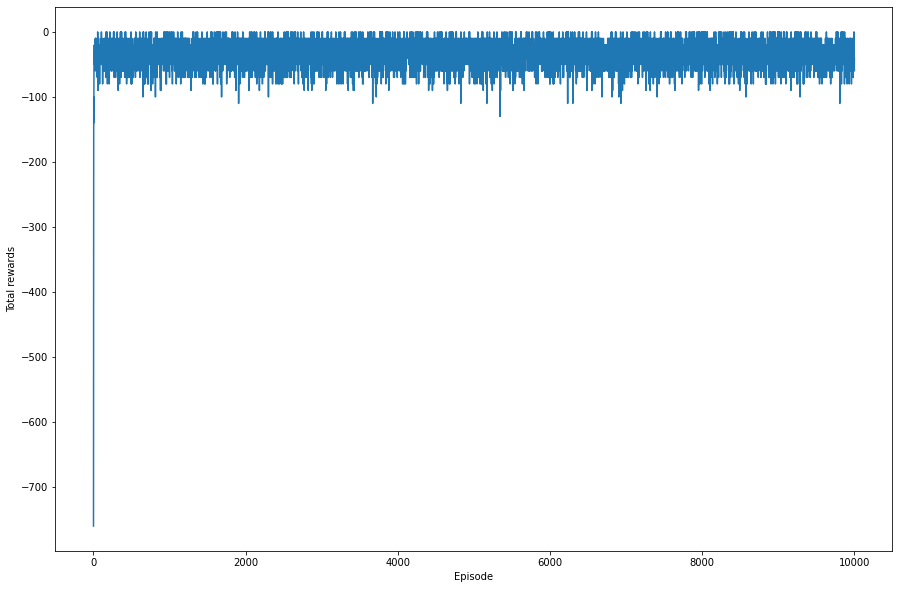

In [13]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

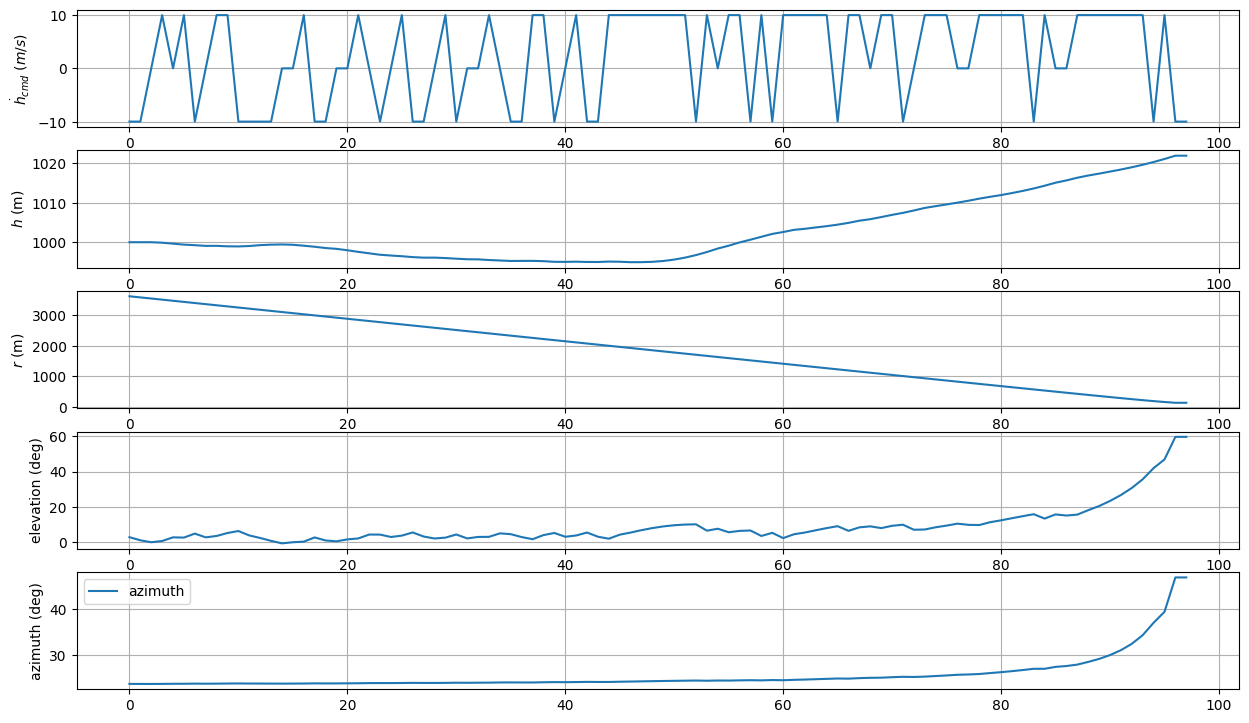

In [16]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[0]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()


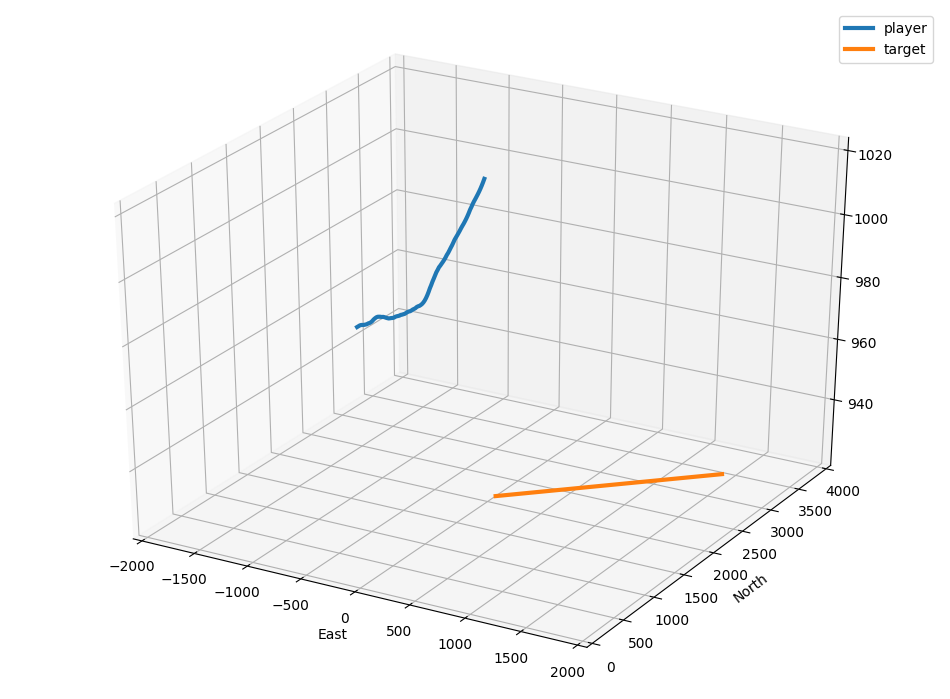

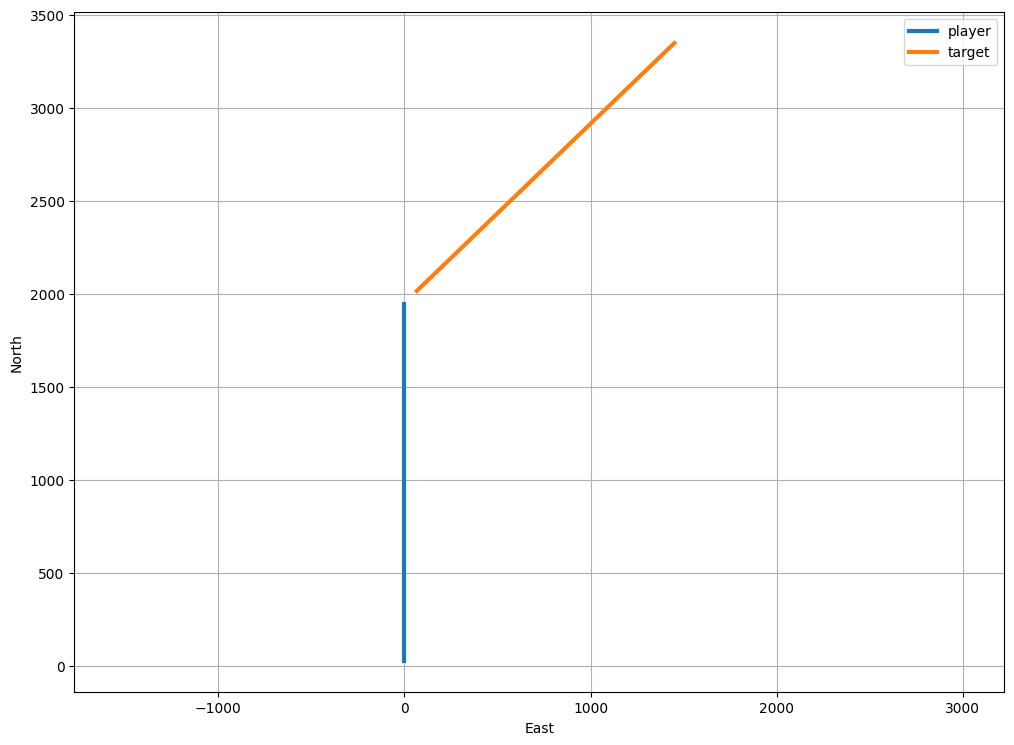

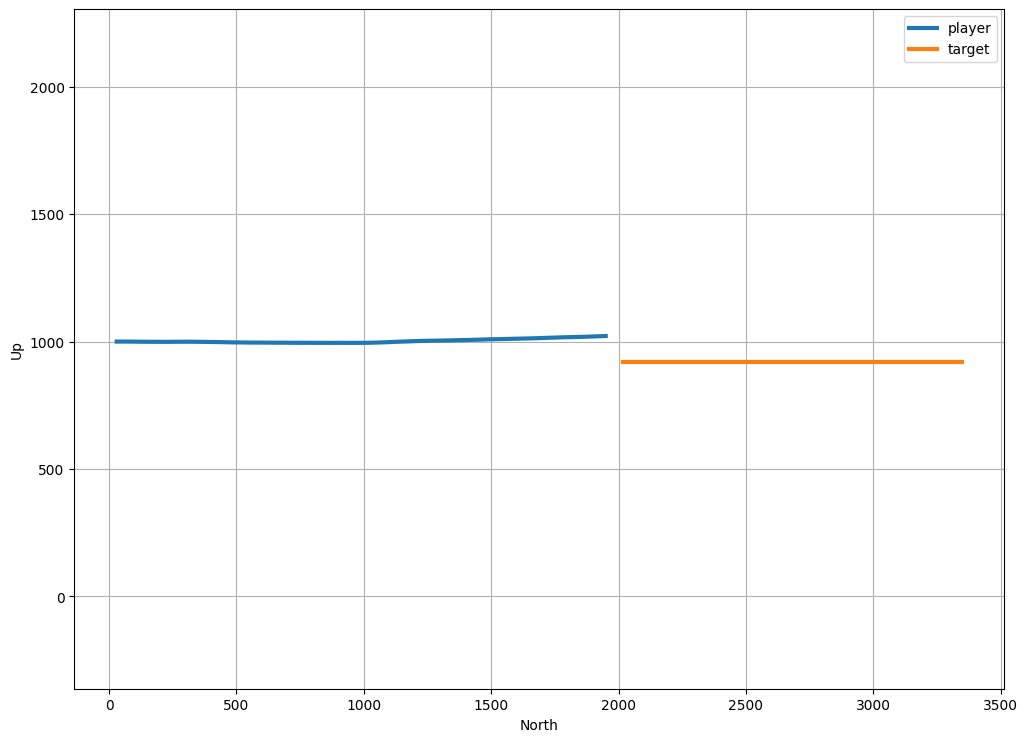

In [17]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

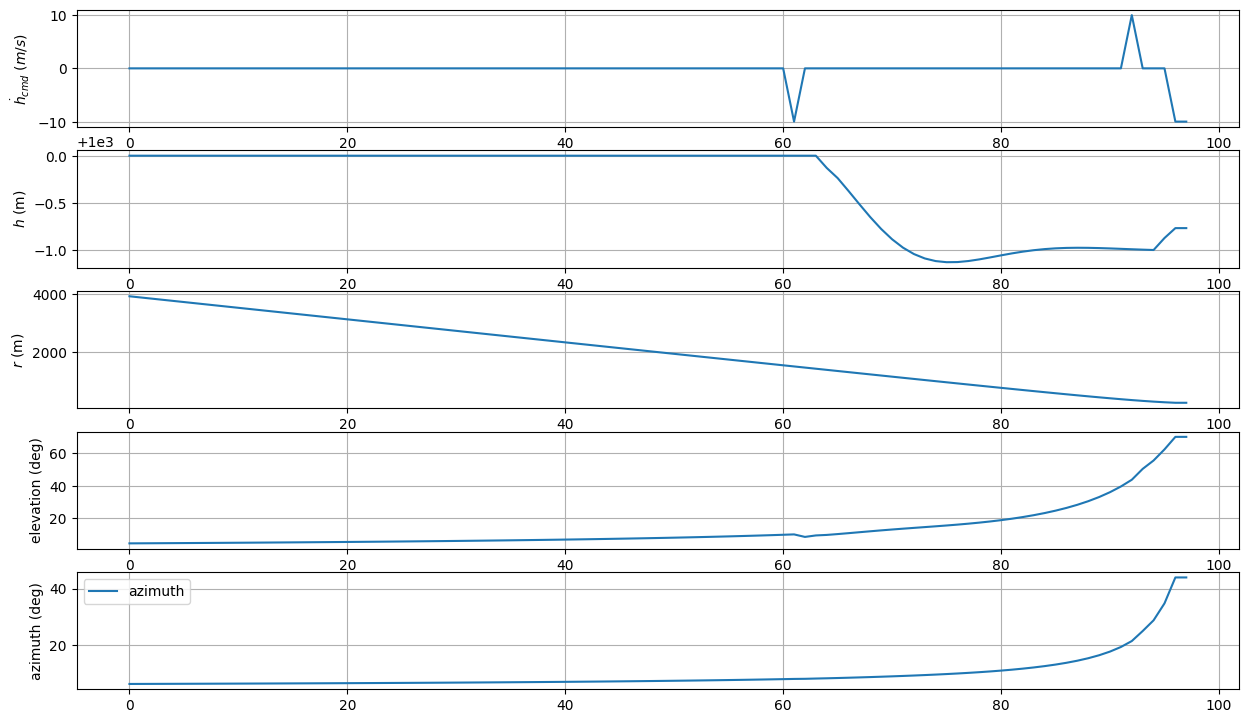

In [18]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[10]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

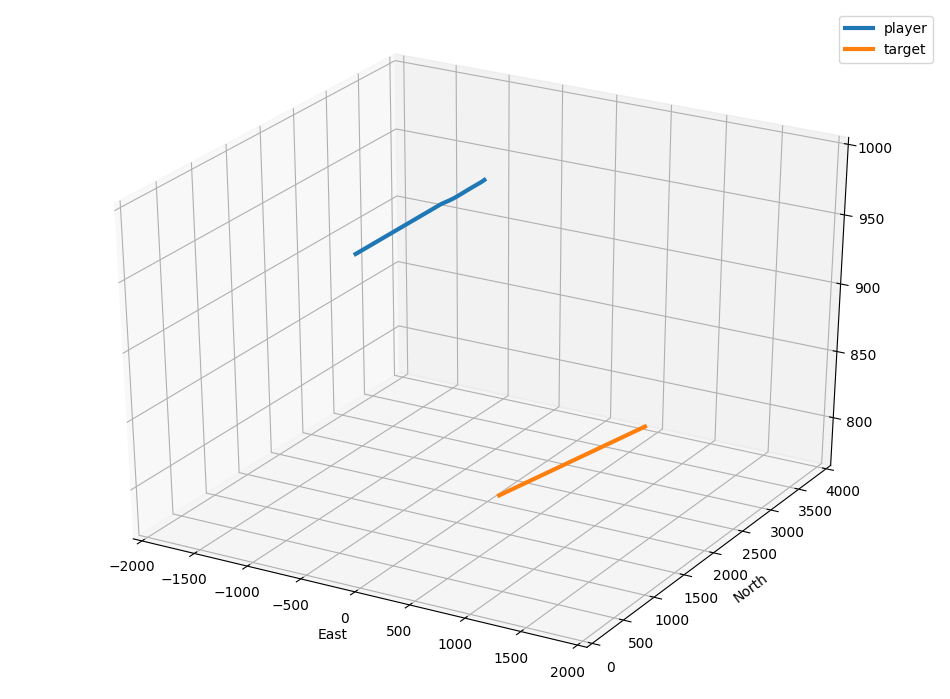

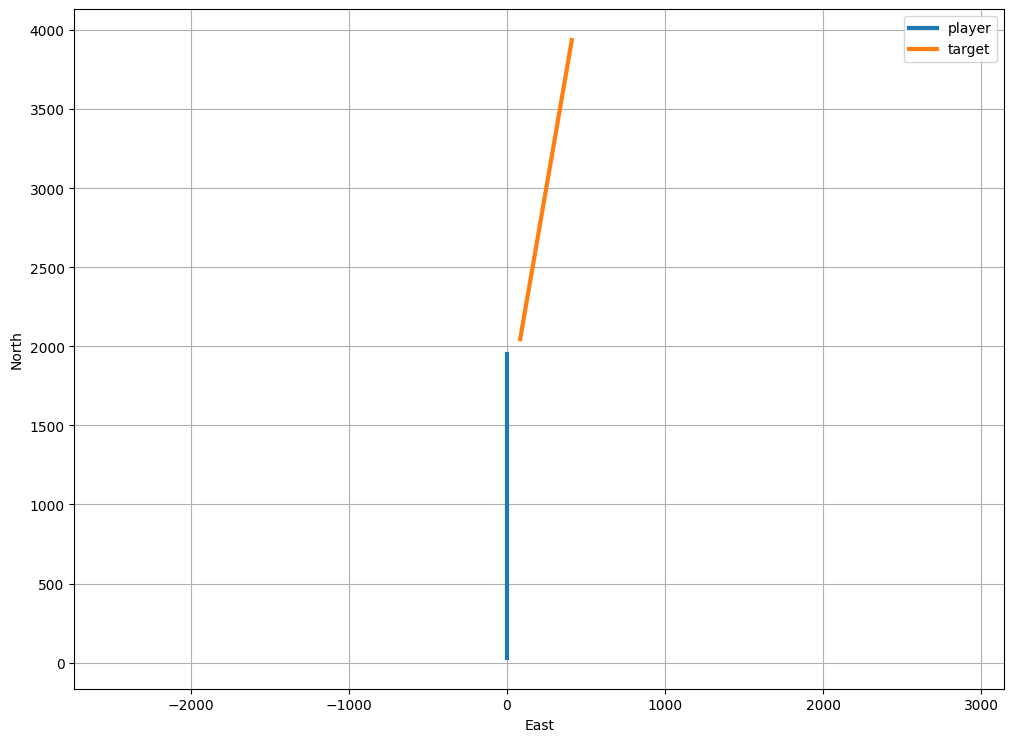

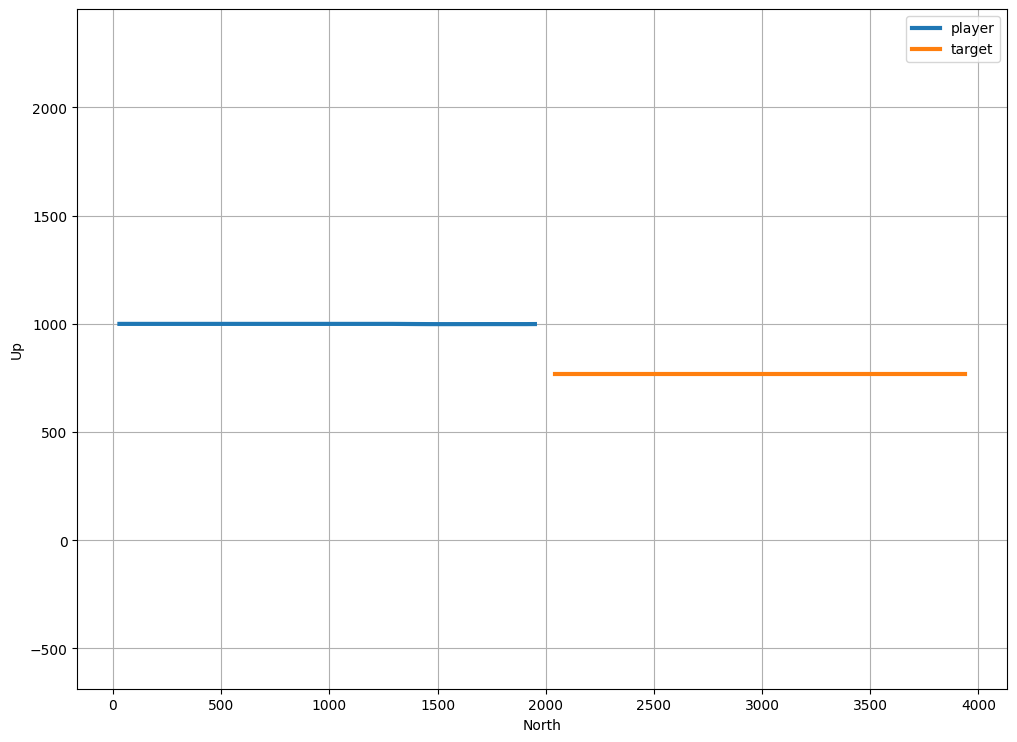

In [19]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

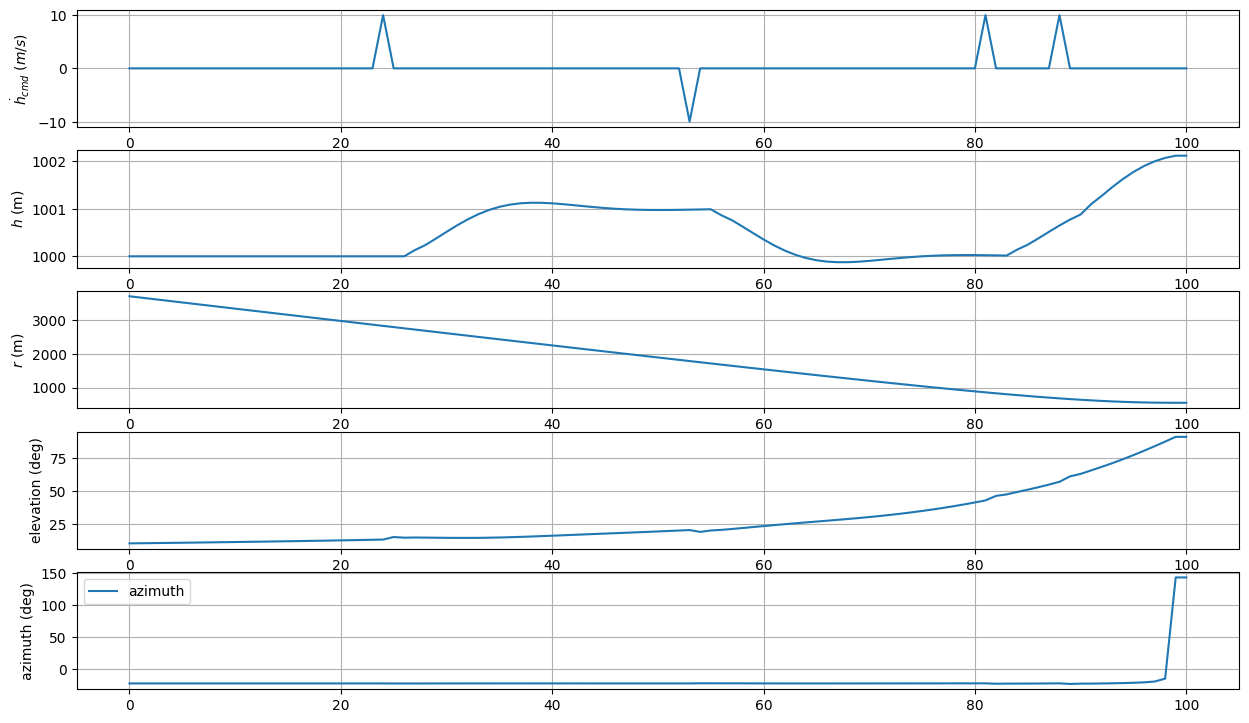

In [20]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[100]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

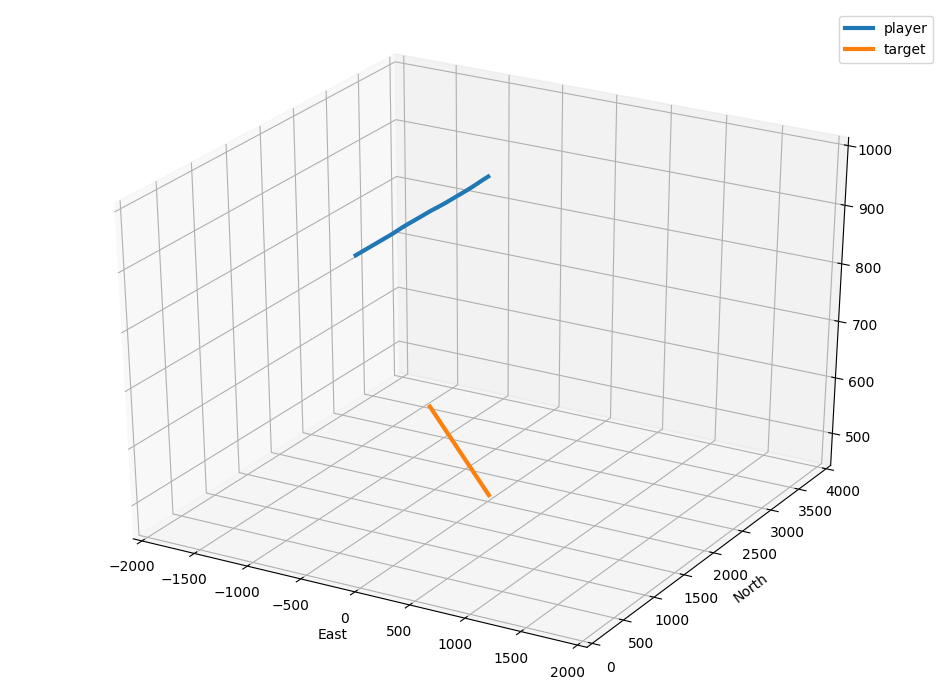

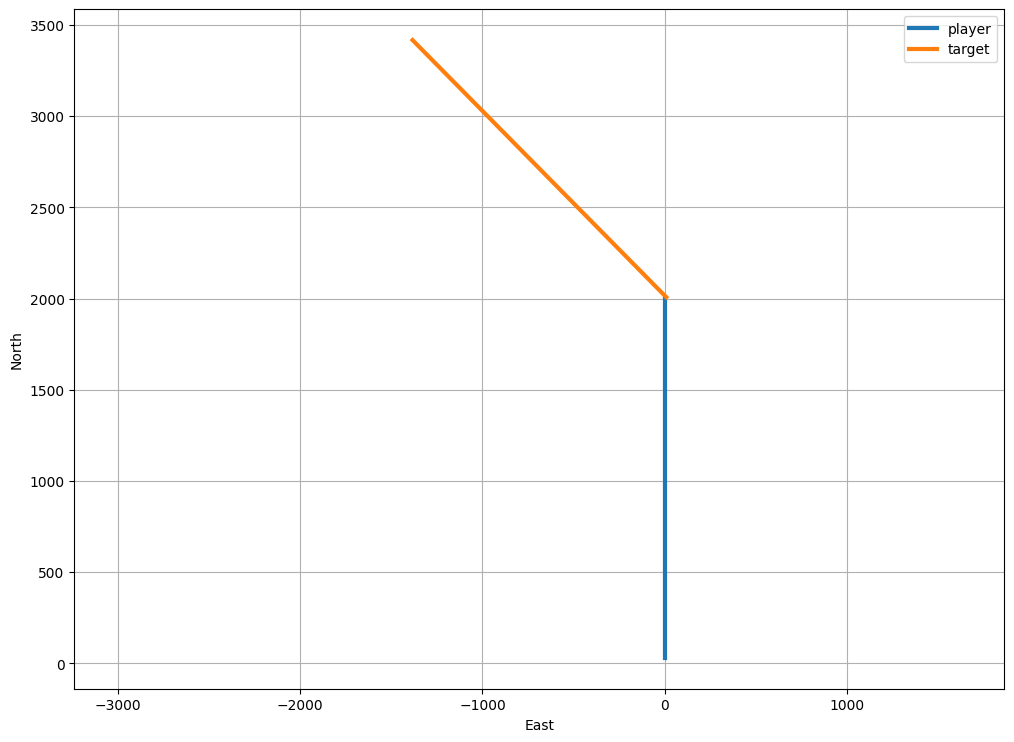

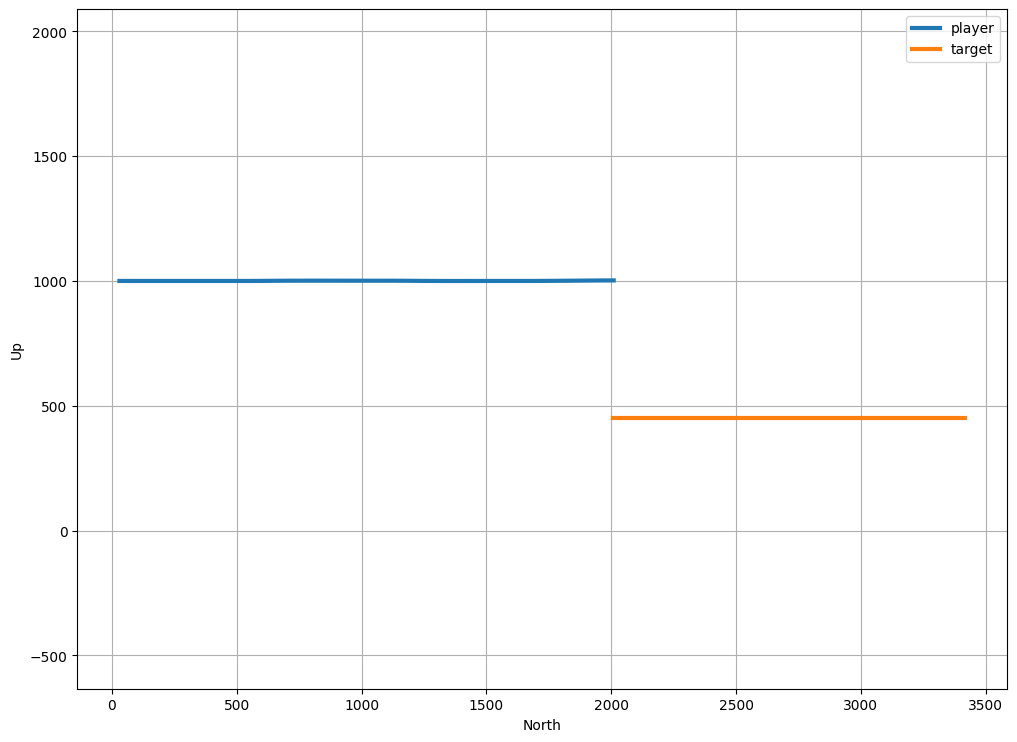

In [21]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

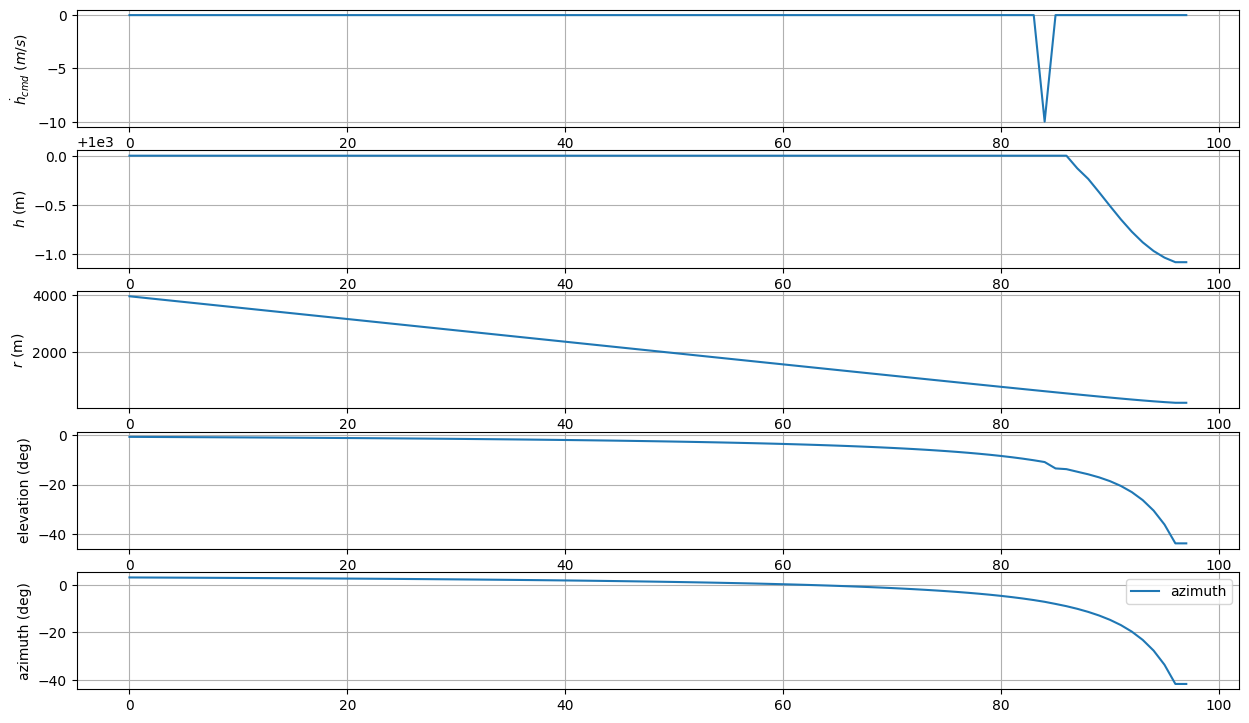

In [22]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[1000]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

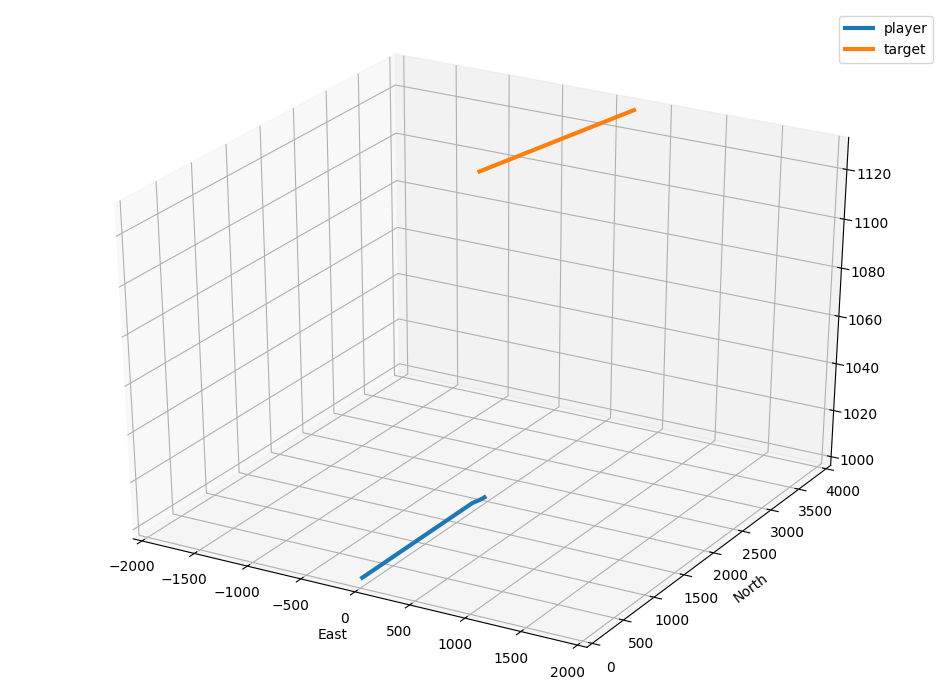

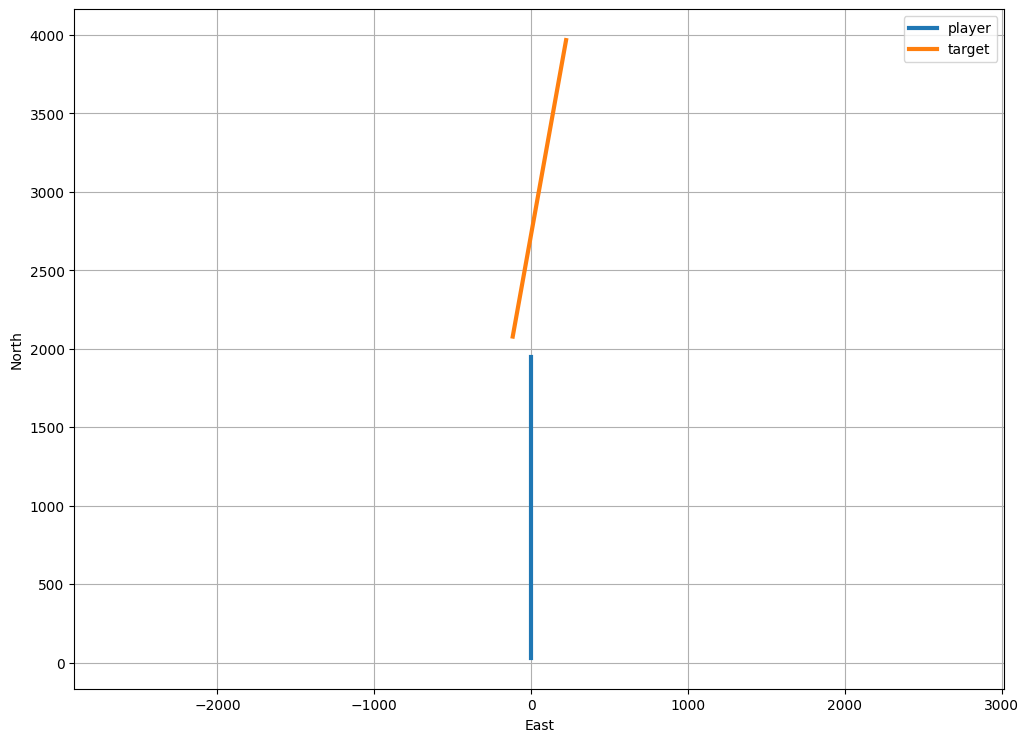

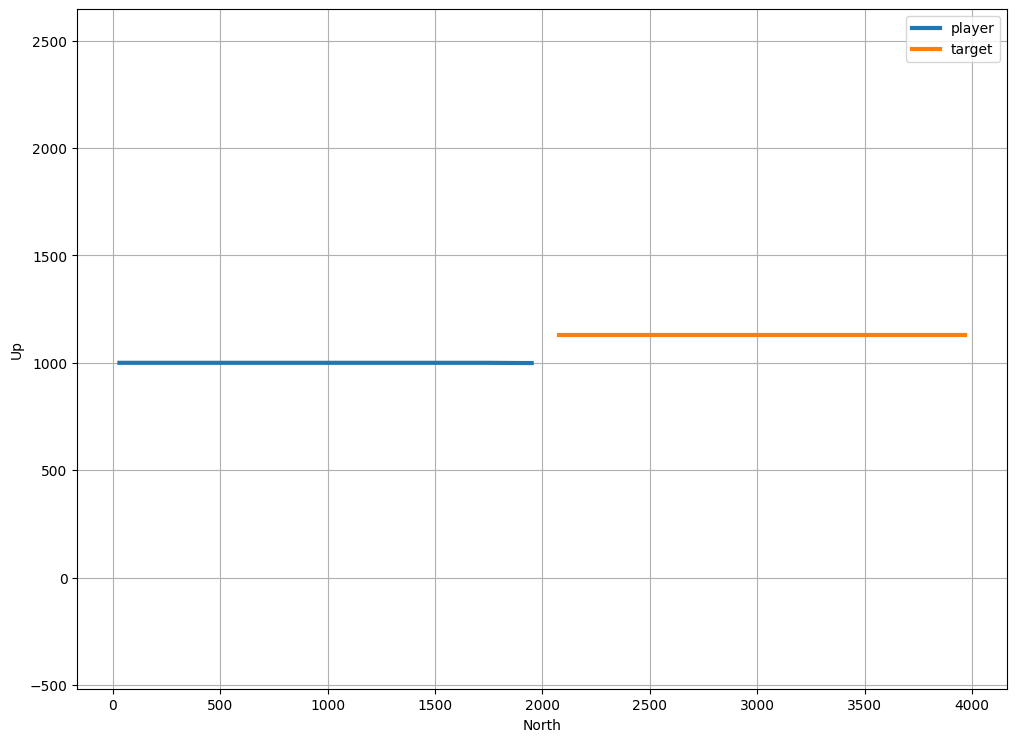

In [23]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

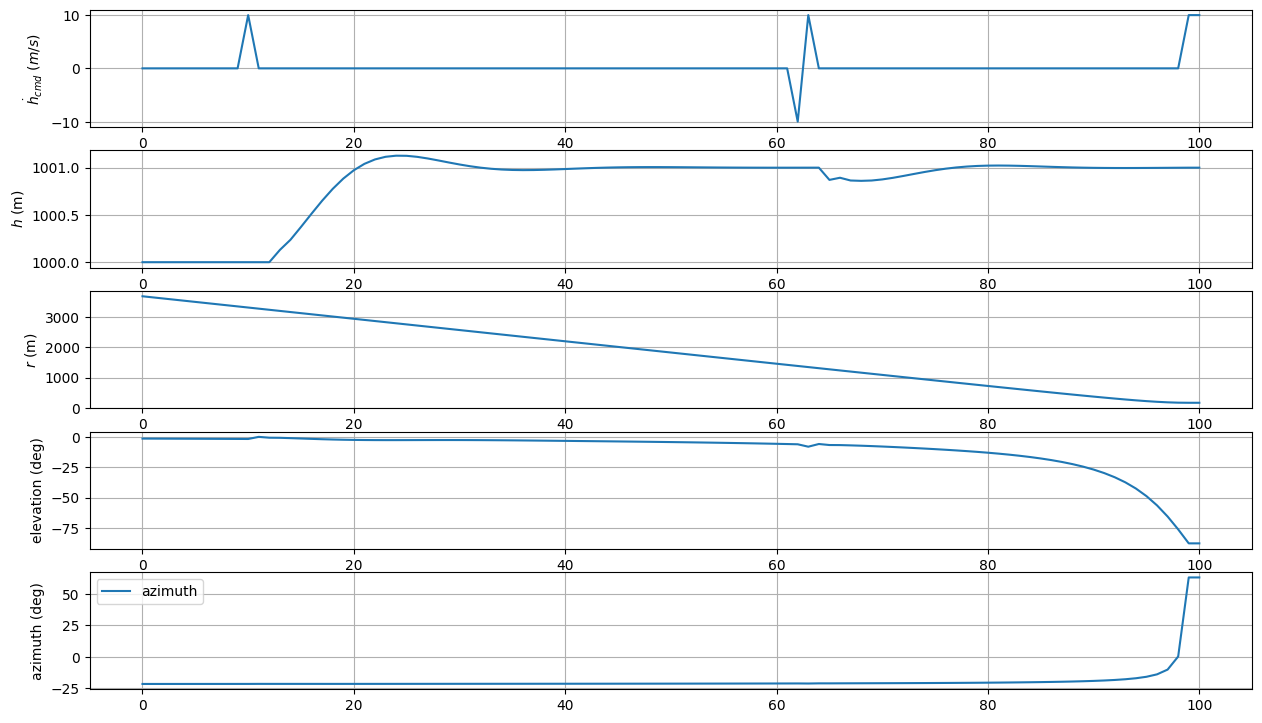

In [24]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[9999]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

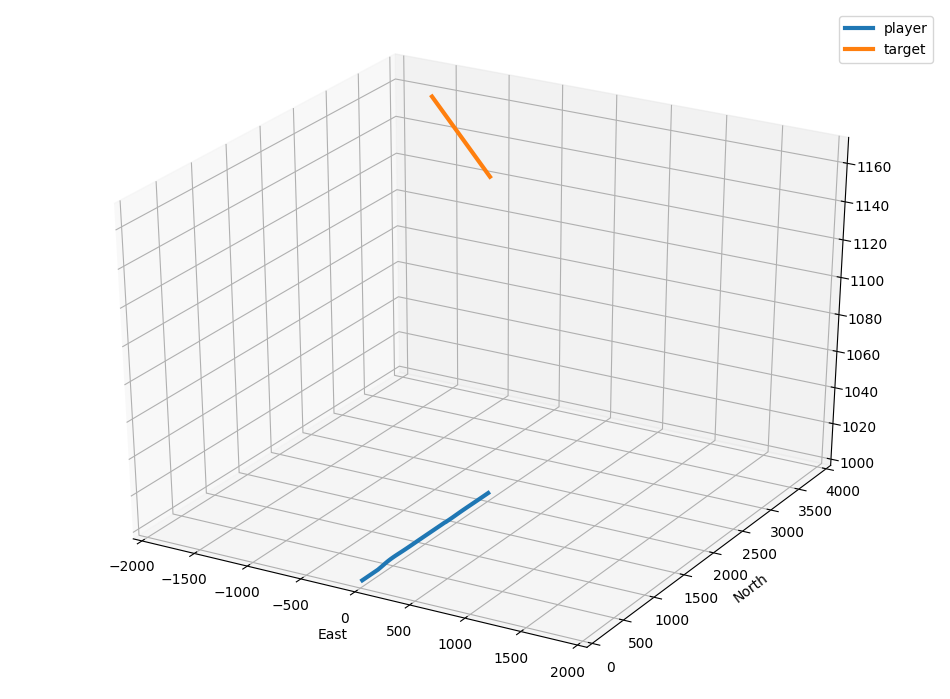

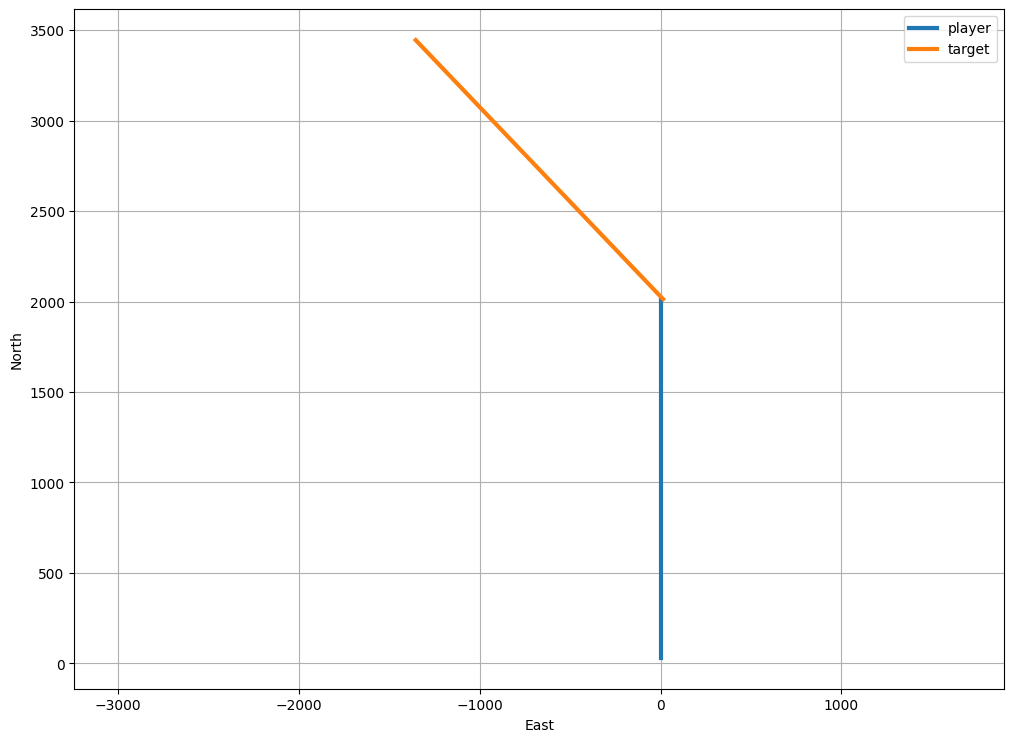

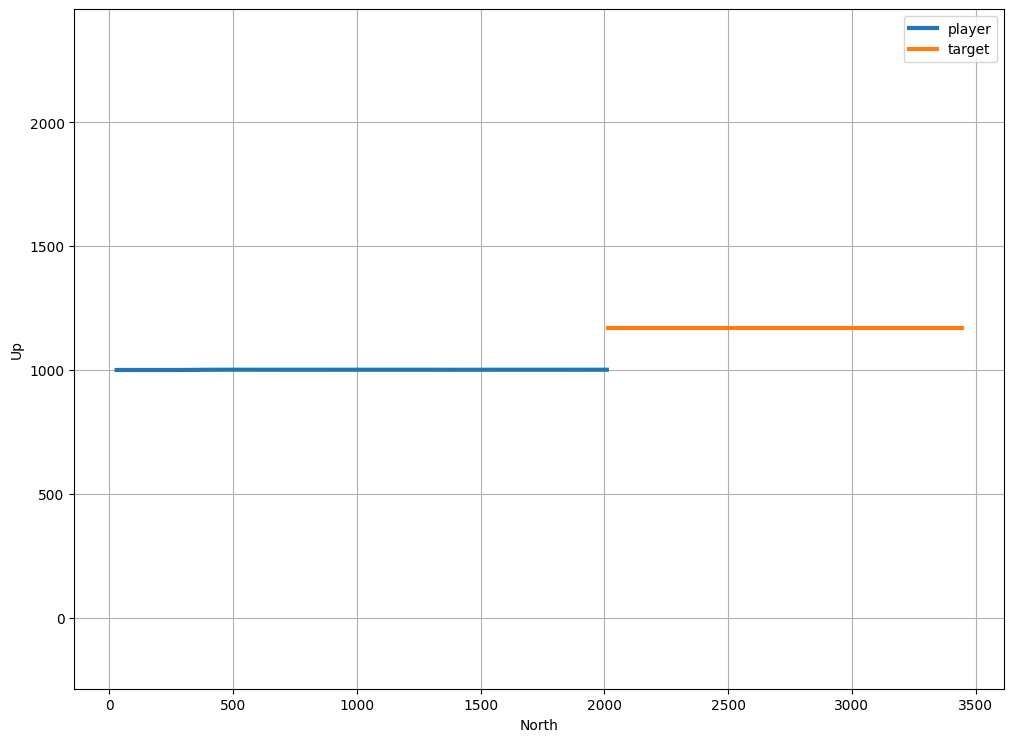

In [25]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()